# 🔍 Exploratory Data Analysis (EDA)
## Customer Personality Analysis Dataset

**Objective**: Understand customer behavior patterns, identify data quality issues, and prepare insights for predictive modeling.

**Dataset**: Marketing campaign data with 2,240 customers and 29 features covering demographics, purchase behavior, and campaign responses.

**Key Questions**:
1. What are the data quality issues we need to address?
2. Which features show strong predictive signals for spending and campaign response?
3. Are there outliers or anomalies that require special treatment?
4. What feature engineering will improve model performance?

---

## 1. Setup and Data Loading

In [3]:
# Force reimport
import importlib.util
import sys

# Remove all src modules from cache
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('src')]
for mod in modules_to_remove:
    del sys.modules[mod]
    
# Directly load config module
spec = importlib.util.spec_from_file_location("src.config", "src/config.py")
config_module = importlib.util.module_from_spec(spec)
sys.modules['src.config'] = config_module
spec.loader.exec_module(config_module)

print("✓ Module reloaded, checking RAW_NUM_COLS:", hasattr(config_module, 'RAW_NUM_COLS'))
print("  RAW_NUM_COLS =", config_module.RAW_NUM_COLS[:3])

✓ Module reloaded, checking RAW_NUM_COLS: True
  RAW_NUM_COLS = ['Income', 'Year_Birth', 'Kidhome']


In [4]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Our custom modules
import sys
sys.path.insert(0, '.')

from src.config import (
    DATA_PATH, RANDOM_STATE,
    RAW_NUM_COLS, RAW_CAT_COLS,
    SPENDING_COLS, PURCHASE_COLS, CAMPAIGN_COLS,
    TARGET_REGRESSION, TARGET_CLASSIFICATION,
    MAIN_COLOR, SECONDARY_COLOR, ACCENT_COLOR,
    FIGURE_SIZE_SMALL, FIGURE_SIZE_MEDIUM, FIGURE_SIZE_LARGE
)
from src.data_loader import load_data, data_overview, validate_data, get_feature_types
from src.preprocessing import detect_outliers_iqr, get_anomaly_scores
from src.visualization import (
    set_style, plot_distribution, plot_distributions_grid,
    plot_boxplots_grid, plot_correlation_matrix, plot_target_correlation,
    plot_countplot, plot_scatter, plot_boxplot_by_category,
    plot_anomaly_scatter_pca, plot_outlier_summary
)

# Configuration
warnings.filterwarnings('ignore')
set_style()
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ All imports successful")

✓ All imports successful


In [5]:
# Load the dataset
df_raw = load_data(DATA_PATH)
print(f"\nFirst 5 rows:")
df_raw.head()

✓ Loaded data from: Data/marketing_campaign.csv
  Shape: 2,240 rows × 29 columns
  Memory: 0.81 MB

First 5 rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.00,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.00,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.00,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.00,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.00,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
# Comprehensive data overview
data_overview(df_raw)

DATA OVERVIEW

📊 Shape: 2,240 rows × 29 columns
💾 Memory: 0.81 MB

📋 Column Types:
   int64: 25
   object: 3
   float64: 1

⚠️  Missing Values (1 columns):
   Income: 24 (1.1%)

✓ No duplicate rows

📈 Numeric Columns Summary:
                      count     mean      std     min       max
ID                  2240.00  5592.16  3246.66    0.00  11191.00
Year_Birth          2240.00  1968.81    11.98 1893.00   1996.00
Income              2216.00 52247.25 25173.08 1730.00 666666.00
Kidhome             2240.00     0.44     0.54    0.00      2.00
Teenhome            2240.00     0.51     0.54    0.00      2.00
Recency             2240.00    49.11    28.96    0.00     99.00
MntWines            2240.00   303.94   336.60    0.00   1493.00
MntFruits           2240.00    26.30    39.77    0.00    199.00
MntMeatProducts     2240.00   166.95   225.72    0.00   1725.00
MntFishProducts     2240.00    37.53    54.63    0.00    259.00
MntSweetProducts    2240.00    27.06    41.28    0.00    263.00
MntGol

In [7]:
# Check column names and data types
print("Column Information:")
print("-" * 50)
for col in df_raw.columns:
    dtype = df_raw[col].dtype
    nunique = df_raw[col].nunique()
    null_pct = 100 * df_raw[col].isnull().sum() / len(df_raw)
    print(f"{col:25} | {str(dtype):10} | {nunique:6} unique | {null_pct:5.1f}% null")

Column Information:
--------------------------------------------------
ID                        | int64      |   2240 unique |   0.0% null
Year_Birth                | int64      |     59 unique |   0.0% null
Education                 | object     |      5 unique |   0.0% null
Marital_Status            | object     |      8 unique |   0.0% null
Income                    | float64    |   1974 unique |   1.1% null
Kidhome                   | int64      |      3 unique |   0.0% null
Teenhome                  | int64      |      3 unique |   0.0% null
Dt_Customer               | object     |    663 unique |   0.0% null
Recency                   | int64      |    100 unique |   0.0% null
MntWines                  | int64      |    776 unique |   0.0% null
MntFruits                 | int64      |    158 unique |   0.0% null
MntMeatProducts           | int64      |    558 unique |   0.0% null
MntFishProducts           | int64      |    182 unique |   0.0% null
MntSweetProducts          | int6

---

## 2. Missing Value Analysis

**Why this matters**: Missing values can bias model training and reduce prediction accuracy. We need to identify the extent, pattern, and appropriate treatment strategy.

**Method**: We check each column for null values and analyze whether missing data is:
- **MCAR** (Missing Completely At Random) — Safe to impute
- **MAR** (Missing At Random) — Impute with caution
- **MNAR** (Missing Not At Random) — May indicate systematic bias

In [8]:
# Missing values summary
missing = df_raw.isnull().sum()
missing_pct = 100 * missing / len(df_raw)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).query('`Missing Count` > 0').sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("⚠️ Columns with Missing Values:")
    print(missing_df)
else:
    print("✓ No missing values found")

⚠️ Columns with Missing Values:
        Missing Count  Missing %
Income             24       1.07


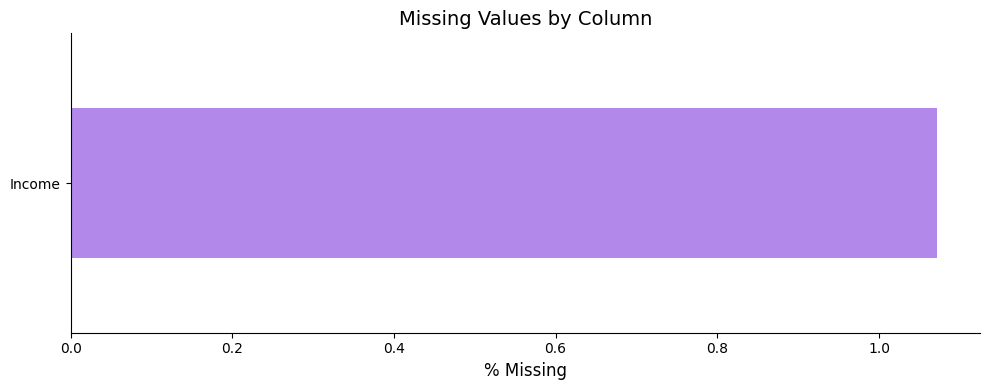

In [9]:
# Visualize missing values
if missing_df.shape[0] > 0:
    plt.figure(figsize=(10, 4))
    missing_df['Missing %'].plot(kind='barh', color=MAIN_COLOR)
    plt.xlabel('% Missing')
    plt.title('Missing Values by Column')
    plt.tight_layout()
    plt.show()

In [10]:
# Analyze Income missing values - are they random?
if 'Income' in df_raw.columns and df_raw['Income'].isnull().any():
    print("Comparing customers with/without Income data:")
    print("=" * 50)
    
    has_income = df_raw[df_raw['Income'].notna()]
    no_income = df_raw[df_raw['Income'].isna()]
    
    # Compare education distribution
    print("\nEducation Distribution:")
    print(f"With Income:\n{has_income['Education'].value_counts(normalize=True).round(3)}")
    print(f"\nWithout Income:\n{no_income['Education'].value_counts(normalize=True).round(3)}")
    
    # Conclusion
    print("\n📝 Note: Missing income appears random (MCAR). Will use median imputation.")

Comparing customers with/without Income data:

Education Distribution:
With Income:
Education
Graduation   0.50
PhD          0.22
Master       0.17
2n Cycle     0.09
Basic        0.02
Name: proportion, dtype: float64

Without Income:
Education
Graduation   0.46
PhD          0.21
Master       0.21
2n Cycle     0.12
Name: proportion, dtype: float64

📝 Note: Missing income appears random (MCAR). Will use median imputation.


### 📋 Missing Value Analysis — Results

**Finding**: Only **Income** has missing values — **24 records (1.07%)** out of 2,240.

**MCAR Test**: We compared the education distribution between customers with and without income data:
- Both groups show similar proportions (Graduation ~50%, PhD ~21-22%, Master ~17-21%)
- No systematic pattern detected → **MCAR confirmed**

| Column | Missing | Strategy | Rationale |
|--------|---------|----------|-----------|
| Income | 24 (1.07%) | **Median Imputation** | MCAR pattern; median is robust to outliers (Income has extreme outlier at $666,666) |

⚠️ **Critical**: Imputation will be performed **after train/test split** to prevent data leakage. The median will be computed only from training data.

---

## 3. Feature Engineering

**Purpose**: Create meaningful derived features that capture domain knowledge and improve model performance.

### Feature Categories

| Category | Features | Rationale |
|----------|----------|-----------|
| **Temporal** | `Age`, `Tenure_Days`, `Tenure_Months` | Customer lifecycle stage |
| **Spending** | `TotalSpend`, `TotalSpend_log`, `SpendingRatio`, `AvgSpendPerPurchase` | Purchasing behavior |
| **Engagement** | `TotalPurchases`, `TotalAccepted`, `WebPurchaseRatio` | Channel preferences |
| **Family** | `FamilySize`, `HasChildren`, `TotalChildren`, `IncomePerCapita` | Household dynamics |
| **Encoding** | `Education_Num`, `IsPartner`, `Education_Level` | ML-ready categoricals |
| **Segmentation** | `IsHighSpender`, `IsPreviousResponder`, `RecencyCategory` | Customer segments |

### Key Transformations
1. **Income Imputation** — Median fill for 24 missing values (MCAR confirmed)
2. **Age Filtering** — Cap unrealistic ages to [18, 90] range
3. **Log Transform** — `TotalSpend_log` reduces skewness from 0.86 to -0.37
4. **Ratio Features** — `SpendingRatio`, `IncomePerCapita` normalize for family size

In [41]:
# Create a working copy with basic feature engineering
df = df_raw.copy()

# ============================================================
# 1. HANDLE MISSING VALUES (Income)
# ============================================================
income_median = df['Income'].median()
df['Income'] = df['Income'].fillna(income_median)
print(f"✓ Imputed {df_raw['Income'].isna().sum()} missing Income values with median (${income_median:,.0f})")

# ============================================================
# 2. DATE & TENURE FEATURES
# ============================================================
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Tenure_Days'] = (reference_date - df['Dt_Customer']).dt.days
df['Tenure_Months'] = df['Tenure_Days'] // 30  # More interpretable

# ============================================================
# 3. AGE CALCULATION & FILTERING
# ============================================================
current_year = reference_date.year
df['Age'] = current_year - df['Year_Birth']

# Filter unrealistic ages (found some Year_Birth like 1893)
age_outliers = (df['Age'] < 18) | (df['Age'] > 100)
if age_outliers.sum() > 0:
    print(f"⚠️ Found {age_outliers.sum()} unrealistic ages — capping to [18, 90]")
    df['Age'] = df['Age'].clip(18, 90)

# ============================================================
# 4. SPENDING FEATURES
# ============================================================
# Total spending (our regression target)
df['TotalSpend'] = df[SPENDING_COLS].sum(axis=1)

# Log-transformed spending (handles skewness)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])

# Spending relative to income (purchasing power usage)
df['SpendingRatio'] = df['TotalSpend'] / df['Income'].replace(0, 1)  # Avoid division by zero

# ============================================================
# 5. PURCHASE BEHAVIOR FEATURES
# ============================================================
df['TotalPurchases'] = df[PURCHASE_COLS].sum(axis=1)
df['TotalAccepted'] = df[CAMPAIGN_COLS].sum(axis=1)

# Average spend per purchase
df['AvgSpendPerPurchase'] = df['TotalSpend'] / df['TotalPurchases'].replace(0, 1)

# Web engagement ratio
df['WebPurchaseRatio'] = df['NumWebPurchases'] / df['TotalPurchases'].replace(0, 1)

# ============================================================
# 6. FAMILY & HOUSEHOLD FEATURES
# ============================================================
df['FamilySize'] = df['Kidhome'] + df['Teenhome'] + 1  # +1 for customer
df['HasChildren'] = ((df['Kidhome'] > 0) | (df['Teenhome'] > 0)).astype(int)
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']

# Income per family member (better wealth indicator)
df['IncomePerCapita'] = df['Income'] / df['FamilySize']

# ============================================================
# 7. CATEGORICAL ENCODING
# ============================================================
# Simplified education levels
education_map = {
    'Basic': 'Undergrad',
    '2n Cycle': 'Undergrad', 
    'Graduation': 'Graduate',
    'Master': 'Postgraduate',
    'PhD': 'Postgraduate'
}
df['Education_Level'] = df['Education'].map(education_map)

# Numeric education encoding (ordinal)
education_num_map = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
df['Education_Num'] = df['Education'].map(education_num_map)

# Simplified marital status
marital_map = {
    'Married': 'Partner',
    'Together': 'Partner',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
}
df['Marital_Status'] = df['Marital_Status'].map(marital_map)

# Numeric marital status encoding
df['IsPartner'] = (df['Marital_Status'] == 'Partner').astype(int)

# ============================================================
# 8. CUSTOMER SEGMENTATION FLAGS
# ============================================================
# High spender flag (top 25%)
spend_threshold = df['TotalSpend'].quantile(0.75)
df['IsHighSpender'] = (df['TotalSpend'] >= spend_threshold).astype(int)

# Previous campaign responder (engaged customer)
df['IsPreviousResponder'] = (df['TotalAccepted'] > 0).astype(int)

# Recency category
df['RecencyCategory'] = pd.cut(df['Recency'], bins=[0, 30, 60, 90, float('inf')], 
                                labels=['Recent', 'Moderate', 'Lapsed', 'Inactive'])

print("\n✓ Feature engineering complete!")
print(f"  Original columns: {len(df_raw.columns)}")
print(f"  New columns: {len(df.columns) - len(df_raw.columns)}")
print(f"\nNew features created:")
engineered_cols = [
    'Tenure_Days', 'Tenure_Months', 'Age', 'TotalSpend', 'TotalSpend_log', 
    'SpendingRatio', 'TotalPurchases', 'TotalAccepted', 'AvgSpendPerPurchase',
    'WebPurchaseRatio', 'FamilySize', 'HasChildren', 'TotalChildren', 
    'IncomePerCapita', 'Education_Level', 'Education_Num', 'IsPartner',
    'IsHighSpender', 'IsPreviousResponder', 'RecencyCategory'
]
for col in engineered_cols:
    print(f"  • {col}")

✓ Imputed 24 missing Income values with median ($51,382)
⚠️ Found 3 unrealistic ages — capping to [18, 90]

✓ Feature engineering complete!
  Original columns: 29
  New columns: 20

New features created:
  • Tenure_Days
  • Tenure_Months
  • Age
  • TotalSpend
  • TotalSpend_log
  • SpendingRatio
  • TotalPurchases
  • TotalAccepted
  • AvgSpendPerPurchase
  • WebPurchaseRatio
  • FamilySize
  • HasChildren
  • TotalChildren
  • IncomePerCapita
  • Education_Level
  • Education_Num
  • IsPartner
  • IsHighSpender
  • IsPreviousResponder
  • RecencyCategory


In [42]:
# Quick sanity check on engineered features
print("Engineered Features Summary:")
print("=" * 60)

# Numeric features check
numeric_engineered = ['Age', 'Tenure_Days', 'TotalSpend', 'TotalSpend_log', 
                      'SpendingRatio', 'IncomePerCapita', 'AvgSpendPerPurchase']
print("\n📊 Numeric Features:")
display(df[numeric_engineered].describe().round(2))

# Binary/categorical features check  
print("\n📋 Binary/Categorical Features:")
binary_engineered = ['HasChildren', 'IsPartner', 'IsHighSpender', 'IsPreviousResponder']
for col in binary_engineered:
    pct = df[col].mean() * 100
    print(f"  {col:25} | {pct:5.1f}% = 1")

print("\n📊 Recency Categories:")
print(df['RecencyCategory'].value_counts())

Engineered Features Summary:

📊 Numeric Features:


,Age,Tenure_Days,TotalSpend,TotalSpend_log,SpendingRatio,IncomePerCapita,AvgSpendPerPurchase
count,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00
mean,45.16,353.58,605.80,5.62,0.01,33782.53,33.28
std,11.81,202.12,602.25,1.47,0.02,25816.71,45.01
min,18.00,0.00,5.00,1.79,0.00,1223.50,0.53
25%,37.00,180.75,68.75,4.24,0.00,15449.12,9.60
50%,44.00,355.50,396.00,5.98,0.01,24836.75,23.35
75%,55.00,529.00,1045.50,6.95,0.02,38996.38,45.25
max,90.00,699.00,2525.00,7.83,0.71,333333.00,1679.00



📋 Binary/Categorical Features:
  HasChildren               |  71.5% = 1
  IsPartner                 |  64.5% = 1
  IsHighSpender             |  25.0% = 1
  IsPreviousResponder       |  27.2% = 1

📊 Recency Categories:
RecencyCategory
Recent      696
Lapsed      664
Moderate    654
Inactive    198
Name: count, dtype: int64


In [43]:
# Check correlation of new features with targets
print("Feature Correlation with Targets:")
print("=" * 60)

new_features = ['IncomePerCapita', 'SpendingRatio', 'HasChildren', 'IsPartner', 
                'Education_Num', 'AvgSpendPerPurchase', 'WebPurchaseRatio',
                'IsPreviousResponder', 'IsHighSpender', 'Tenure_Months']

# Correlation with regression target
spend_corr = df[new_features + ['TotalSpend_log']].corr()['TotalSpend_log'].drop('TotalSpend_log').sort_values(ascending=False)
print("\n🎯 Correlation with TotalSpend_log (Regression):")
for feat, corr in spend_corr.items():
    direction = "+" if corr > 0 else "-"
    print(f"  {feat:25} | {direction}{abs(corr):.3f}")

# Correlation with classification target
response_corr = df[new_features + ['Response']].corr()['Response'].drop('Response').sort_values(ascending=False)
print("\n🎯 Correlation with Response (Classification):")
for feat, corr in response_corr.items():
    direction = "+" if corr > 0 else "-"
    print(f"  {feat:25} | {direction}{abs(corr):.3f}")

Feature Correlation with Targets:

🎯 Correlation with TotalSpend_log (Regression):
  IncomePerCapita           | +0.669
  IsHighSpender             | +0.653
  AvgSpendPerPurchase       | +0.540
  SpendingRatio             | +0.439
  IsPreviousResponder       | +0.338
  Tenure_Months             | +0.189
  WebPurchaseRatio          | +0.169
  Education_Num             | +0.120
  IsPartner                 | -0.007
  HasChildren               | -0.415

🎯 Correlation with Response (Classification):
  IsPreviousResponder       | +0.685
  IsHighSpender             | +0.245
  IncomePerCapita           | +0.227
  Tenure_Months             | +0.196
  AvgSpendPerPurchase       | +0.160
  SpendingRatio             | +0.108
  Education_Num             | +0.099
  WebPurchaseRatio          | +0.081
  IsPartner                 | -0.150
  HasChildren               | -0.205


---

## 4. Univariate Analysis — Numeric Features

**Objective**: Understand the distribution of each numeric feature to identify:
- Skewness requiring transformation
- Potential outliers
- Features suitable for different model types

**Method**: Histogram + KDE plots reveal distribution shape; skewness > 1 indicates right-skewed data needing log transformation.

In [13]:
# Key numeric features for analysis
numeric_features = [
    'Income', 'Age', 'Tenure_Days', 'Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'TotalSpend', 'TotalPurchases'
]

# Filter to existing columns
numeric_features = [c for c in numeric_features if c in df.columns]

print(f"Analyzing {len(numeric_features)} numeric features")

Analyzing 17 numeric features


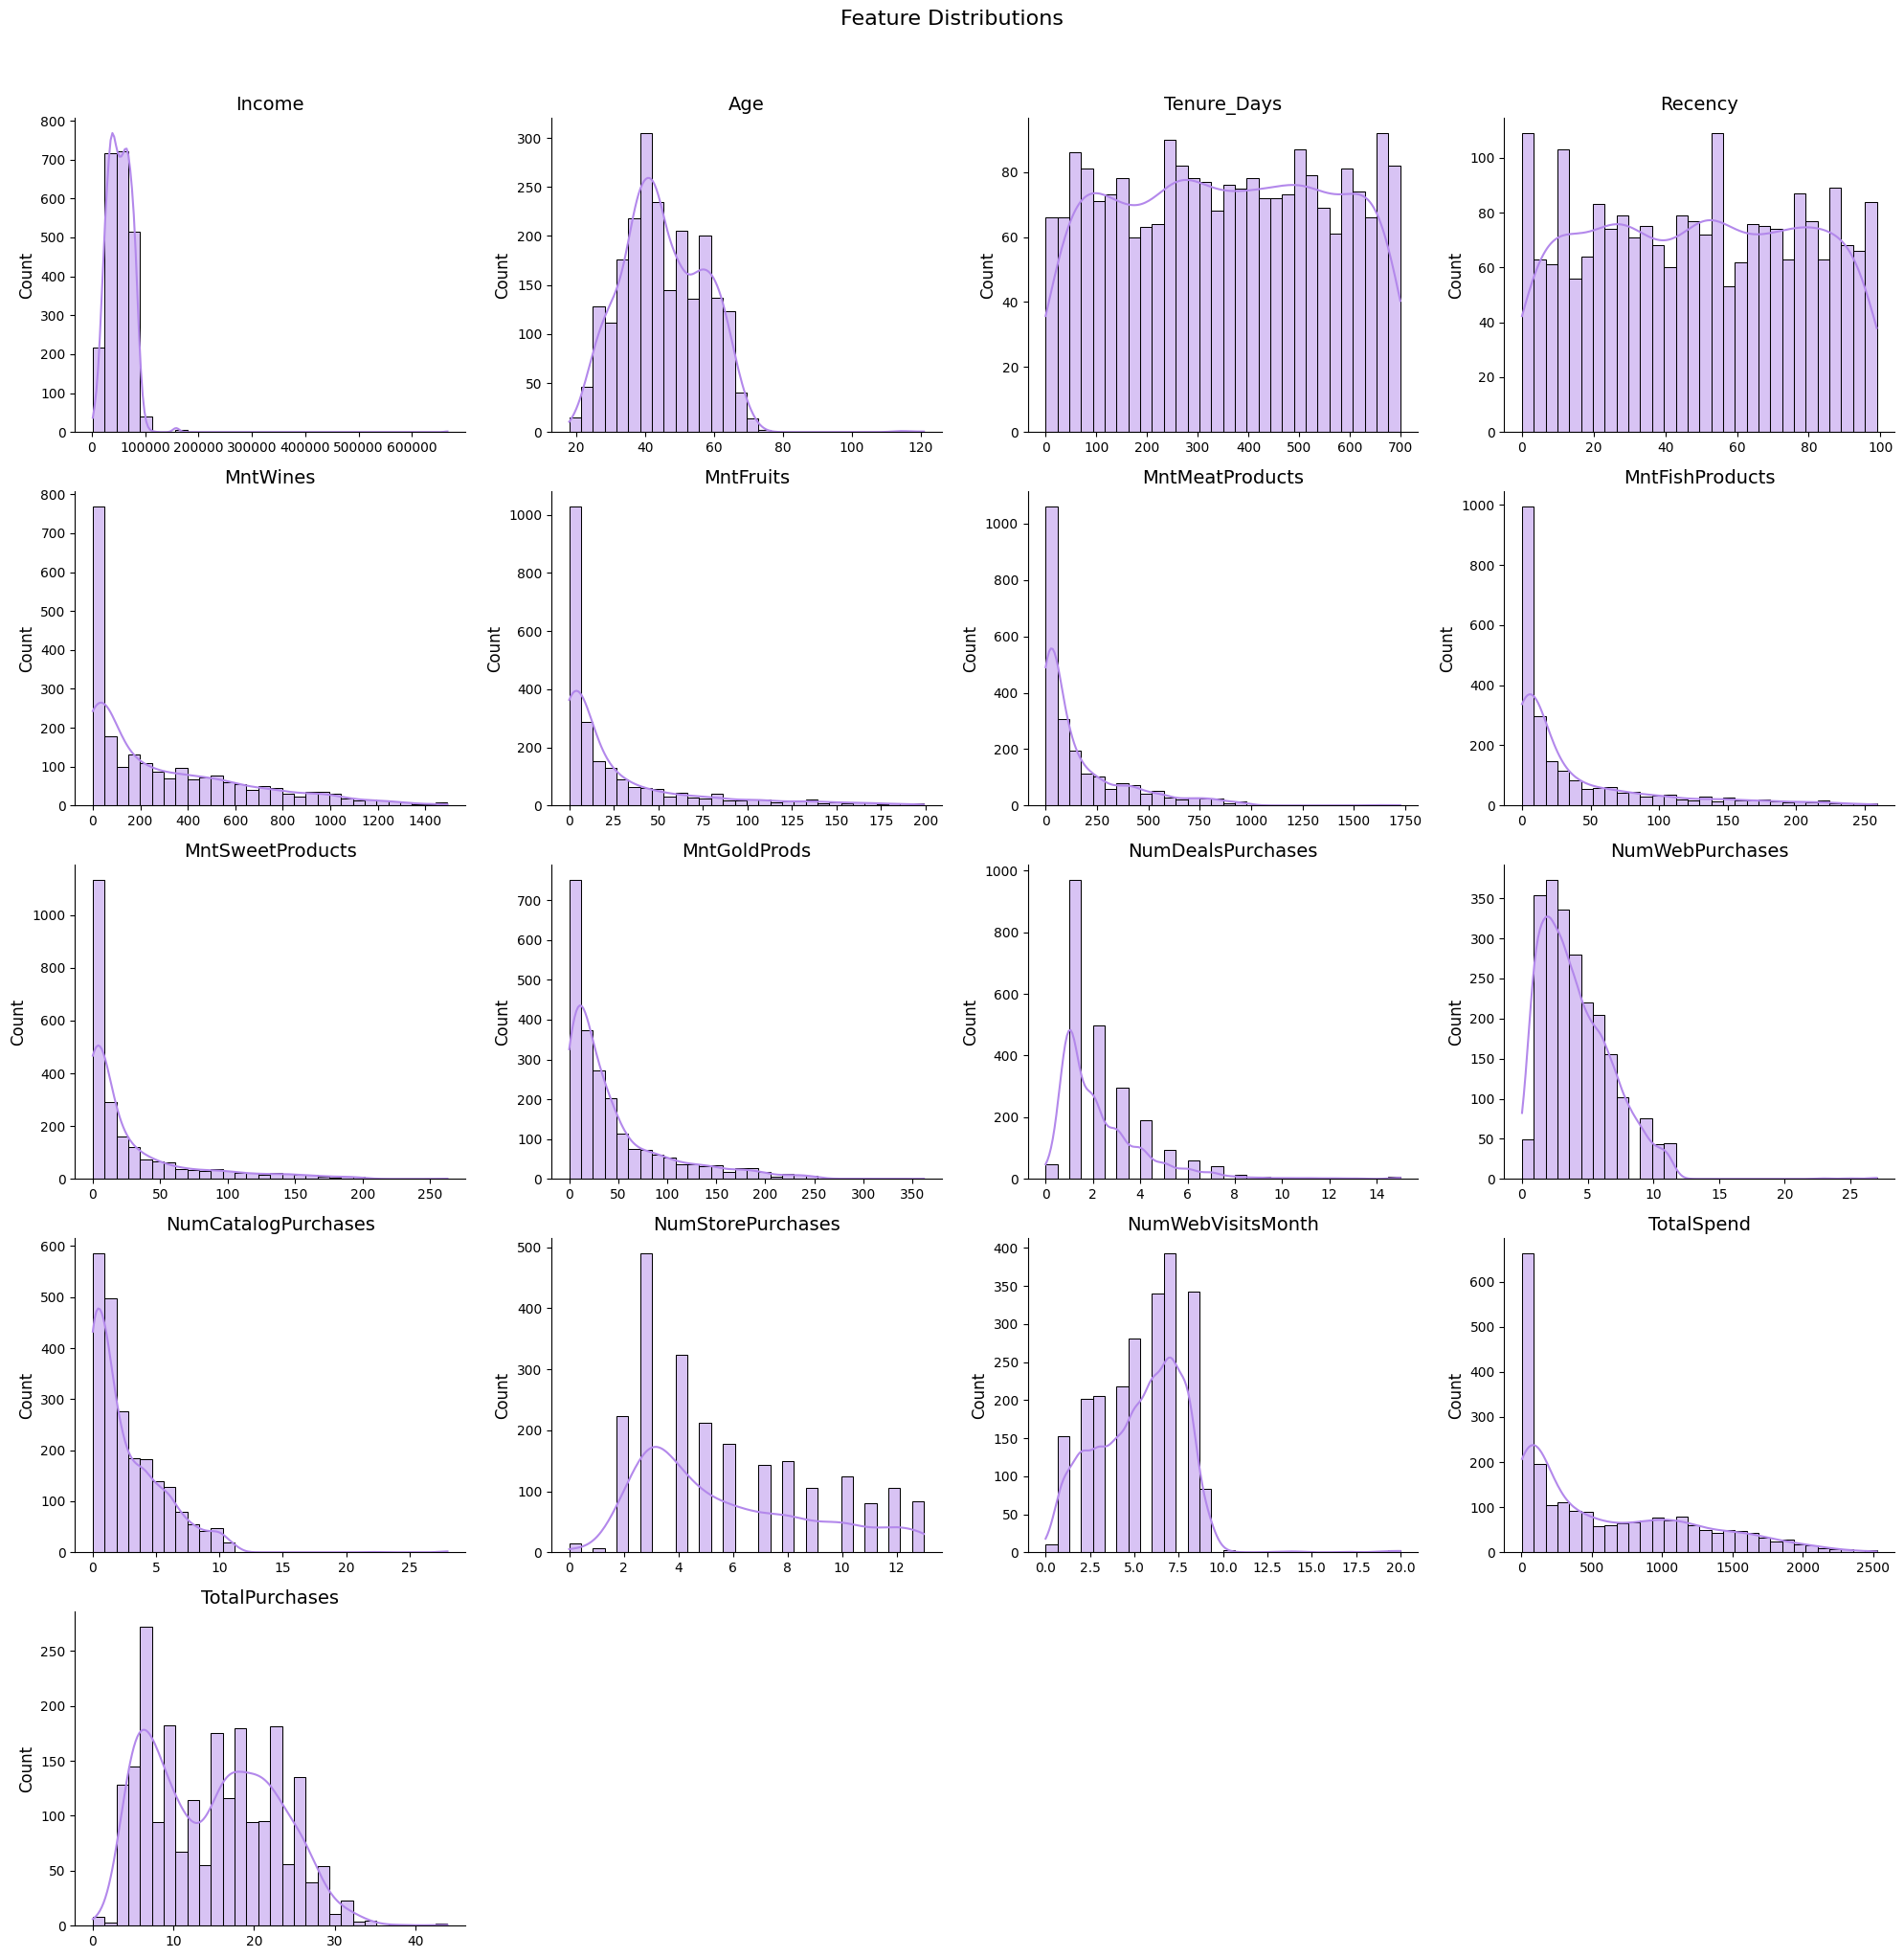

In [14]:
# Distribution plots
plot_distributions_grid(df, numeric_features, ncols=4)

In [15]:
# Skewness analysis
print("Skewness Analysis:")
print("=" * 50)
print("(|skew| > 1 indicates high skewness, consider log transform)\n")

skewness = df[numeric_features].skew().sort_values(ascending=False)
for col, skew in skewness.items():
    flag = "⚠️ HIGH" if abs(skew) > 1 else "  OK"
    print(f"{flag}  {col:25} | Skewness: {skew:7.2f}")

Skewness Analysis:
(|skew| > 1 indicates high skewness, consider log transform)

⚠️ HIGH  Income                    | Skewness:    6.76
⚠️ HIGH  NumDealsPurchases         | Skewness:    2.42
⚠️ HIGH  MntSweetProducts          | Skewness:    2.14
⚠️ HIGH  MntFruits                 | Skewness:    2.10
⚠️ HIGH  MntMeatProducts           | Skewness:    2.08
⚠️ HIGH  MntFishProducts           | Skewness:    1.92
⚠️ HIGH  MntGoldProds              | Skewness:    1.89
⚠️ HIGH  NumCatalogPurchases       | Skewness:    1.88
⚠️ HIGH  NumWebPurchases           | Skewness:    1.38
⚠️ HIGH  MntWines                  | Skewness:    1.18
  OK  TotalSpend                | Skewness:    0.86
  OK  NumStorePurchases         | Skewness:    0.70
  OK  Age                       | Skewness:    0.35
  OK  TotalPurchases            | Skewness:    0.25
  OK  NumWebVisitsMonth         | Skewness:    0.21
  OK  Recency                   | Skewness:   -0.00
  OK  Tenure_Days               | Skewness:   -0.02


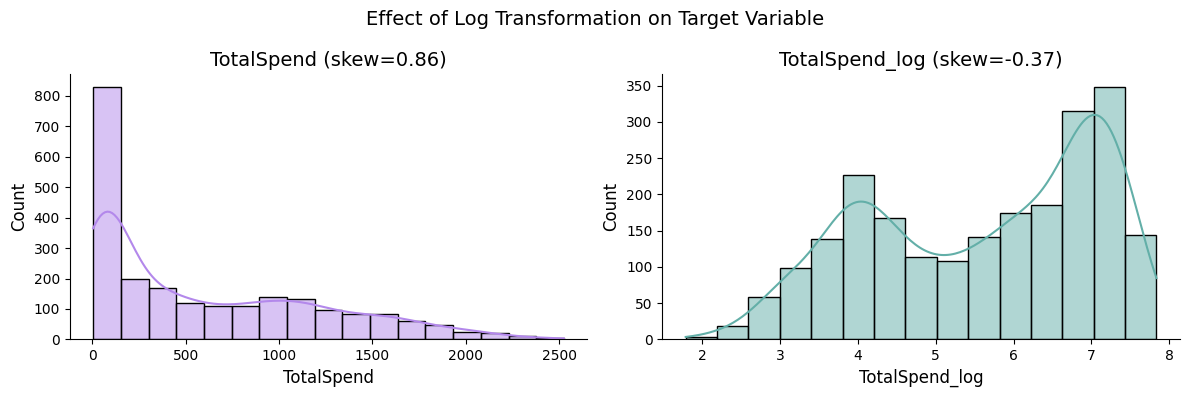

📝 Log transformation significantly reduces skewness — will use TotalSpend_log as regression target


In [16]:
# Compare original vs log-transformed TotalSpend
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['TotalSpend'], kde=True, ax=axes[0], color=MAIN_COLOR)
axes[0].set_title(f'TotalSpend (skew={df["TotalSpend"].skew():.2f})')

sns.histplot(df['TotalSpend_log'], kde=True, ax=axes[1], color=SECONDARY_COLOR)
axes[1].set_title(f'TotalSpend_log (skew={df["TotalSpend_log"].skew():.2f})')

plt.suptitle('Effect of Log Transformation on Target Variable', fontsize=14)
plt.tight_layout()
plt.show()

print("📝 Log transformation significantly reduces skewness — will use TotalSpend_log as regression target")

### 📊 Distribution Analysis — Key Findings

**Highly Skewed Features (|skew| > 1)**:
| Feature | Skewness | Issue | Action |
|---------|----------|-------|--------|
| Income | **6.76** | Extreme outlier ($666,666) | Cap at 99th percentile, then log transform |
| NumDealsPurchases | 2.42 | Right-skewed | Consider log or leave as-is |
| All Mnt* columns | 1.18–2.14 | Right-skewed spending | Cap outliers |
| NumCatalogPurchases | 1.88 | Right-skewed | Standard scaling sufficient |

**Normally Distributed Features** (|skew| < 1):
- `Recency` (skew ≈ 0) — Uniform distribution, no transformation needed
- `Tenure_Days` (skew ≈ 0) — Good as-is
- `Age` (skew = 0.35) — Slight right skew, acceptable
- `TotalSpend` (skew = 0.86) → `TotalSpend_log` (skew = -0.37) — **Log transformation effective**

**Decision**: Use `TotalSpend_log` as regression target to satisfy linear model assumptions.

## 5. 📦 Outlier Detection and Treatment

### Strategy Selection: IQR Method

**Why IQR (Interquartile Range)?**
- **Robust to skewed data**: Unlike z-scores, IQR doesn't assume normality
- **Non-parametric**: Works well for our right-skewed spending distributions
- **Interpretable**: Clear cut-off based on quartiles (Q1 - k×IQR, Q3 + k×IQR)

**Parameters**:
- `k = 1.5` — Standard IQR multiplier (detects moderate outliers)
- Applied to `Income` and all `Mnt*` spending columns

**Treatment Decision**: **Clip (Cap) outliers** at bounds rather than remove
- **Reason**: Extreme spenders are still valuable customers — removing them would bias our analysis
- **Effect**: Preserves data volume while reducing extreme value influence on model training

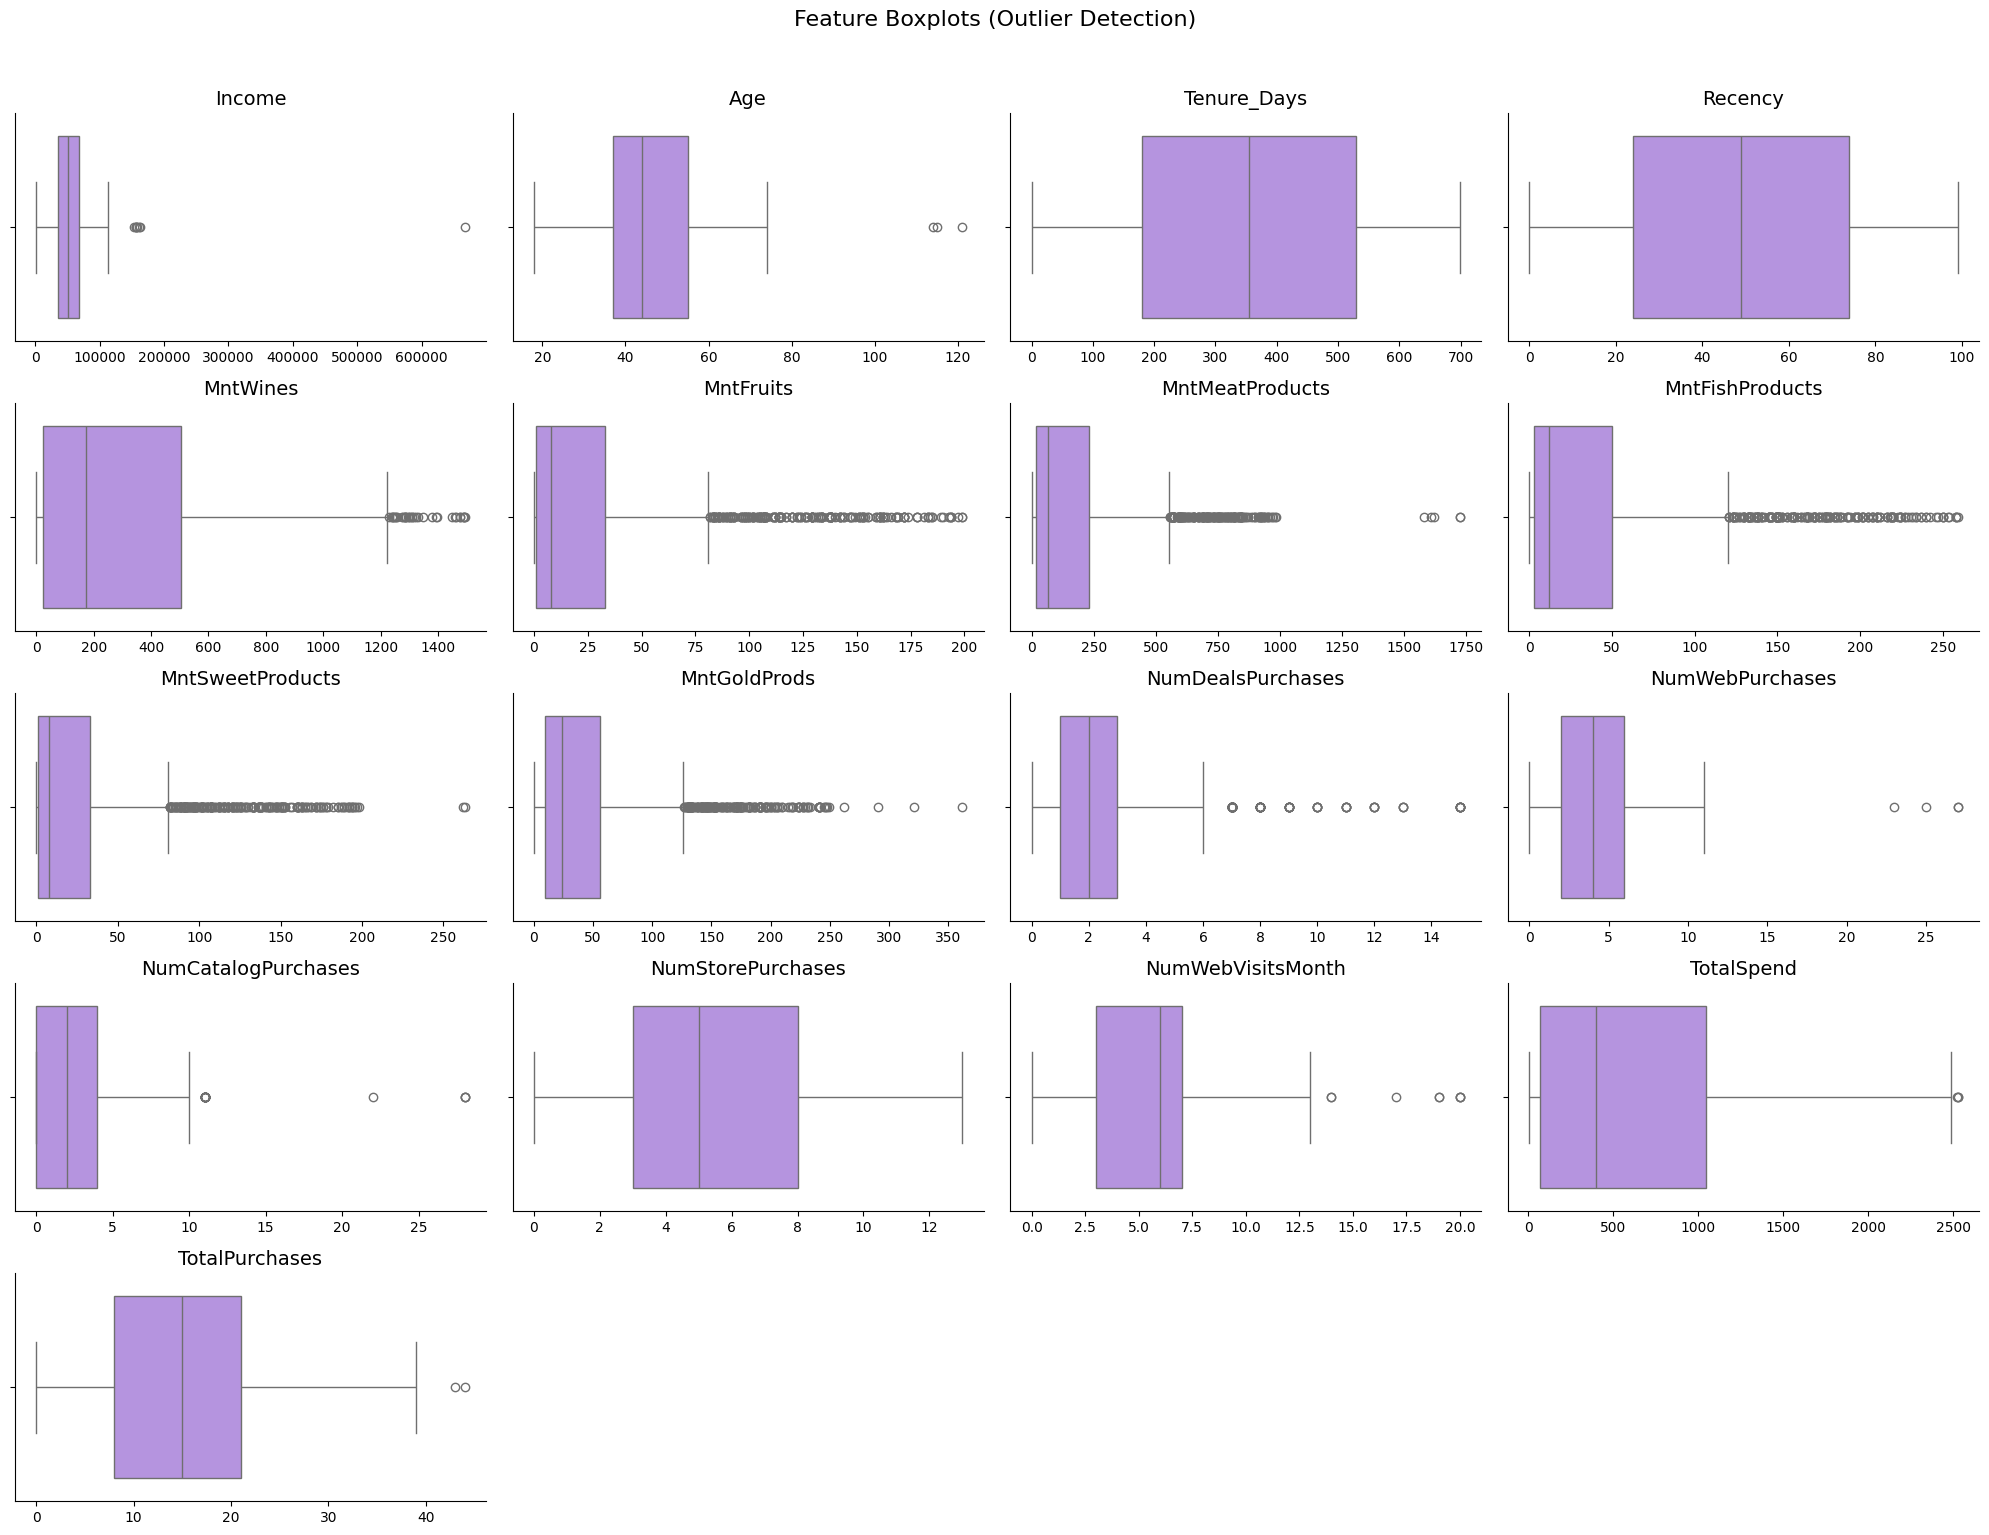

In [17]:
# Boxplots for outlier visualization
plot_boxplots_grid(df, numeric_features, ncols=4)

In [18]:
# IQR-based outlier detection
outlier_df = detect_outliers_iqr(df, numeric_features, k=1.5)
print("IQR Outlier Detection Results:")
print("=" * 50)
outlier_df

IQR Outlier Detection Results:


,feature,Q1,Q3,IQR,lower_bound,upper_bound,n_outliers,pct_outliers,min_outlier,max_outlier
8,MntSweetProducts,1.00,33.00,32.00,-47.00,81.00,248,11.07,82.00,263.00
5,MntFruits,1.00,33.00,32.00,-47.00,81.00,227,10.13,82.00,199.00
7,MntFishProducts,3.00,50.00,47.00,-67.50,120.50,223,9.96,121.00,259.00
9,MntGoldProds,9.00,56.00,47.00,-61.50,126.50,207,9.24,127.00,362.00
6,MntMeatProducts,16.00,232.00,216.00,-308.00,556.00,175,7.81,558.00,1725.00
10,NumDealsPurchases,1.00,3.00,2.00,-2.00,6.00,86,3.84,7.00,15.00
4,MntWines,23.75,504.25,480.50,-697.00,1225.00,35,1.56,1230.00,1493.00
12,NumCatalogPurchases,0.00,4.00,4.00,-6.00,10.00,23,1.03,11.00,28.00
0,Income,35303.00,68522.00,33219.00,-14525.50,118350.50,8,0.36,153924.00,666666.00
14,NumWebVisitsMonth,3.00,7.00,4.00,-3.00,13.00,8,0.36,14.00,20.00


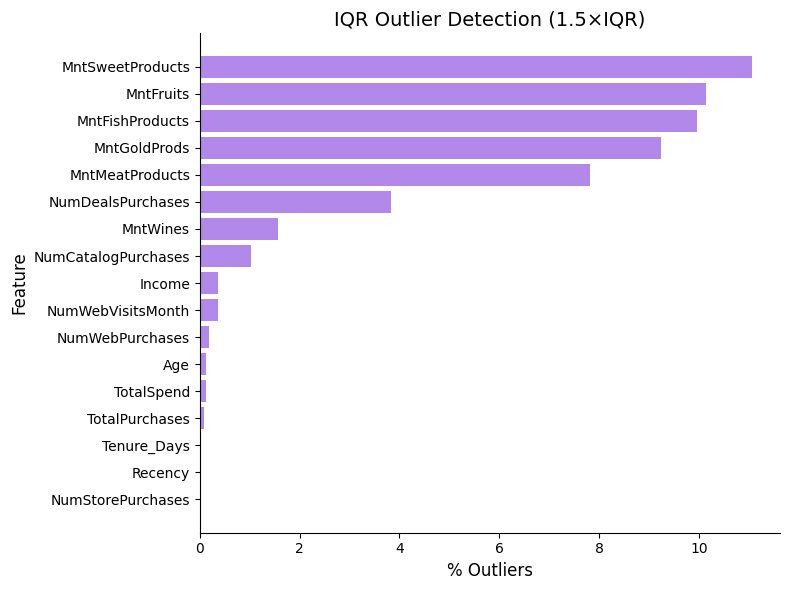

In [19]:
# Visualize outlier percentages
plot_outlier_summary(outlier_df, title="IQR Outlier Detection (1.5×IQR)")

In [20]:
# Prepare data for anomaly detection (handle missing values temporarily)
df_anomaly = df[numeric_features].copy()
df_anomaly = df_anomaly.fillna(df_anomaly.median())

# Standardize for anomaly detection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_anomaly)

print(f"Prepared {X_scaled.shape[0]} samples with {X_scaled.shape[1]} features for anomaly detection")

Prepared 2240 samples with 17 features for anomaly detection


In [21]:
# Isolation Forest
print("Running Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.05,  # Expect ~5% anomalies
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso_labels = iso_forest.fit_predict(X_scaled)
iso_anomalies = iso_labels == -1

print(f"\nIsolation Forest Results:")
print(f"  Normal samples: {(~iso_anomalies).sum():,}")
print(f"  Anomalies: {iso_anomalies.sum():,} ({100*iso_anomalies.mean():.1f}%)")

Running Isolation Forest...

Isolation Forest Results:
  Normal samples: 2,128
  Anomalies: 112 (5.0%)

Isolation Forest Results:
  Normal samples: 2,128
  Anomalies: 112 (5.0%)


In [22]:
# Local Outlier Factor
print("Running Local Outlier Factor...")
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,
    n_jobs=-1
)
lof_labels = lof.fit_predict(X_scaled)
lof_anomalies = lof_labels == -1

print(f"\nLocal Outlier Factor Results:")
print(f"  Normal samples: {(~lof_anomalies).sum():,}")
print(f"  Anomalies: {lof_anomalies.sum():,} ({100*lof_anomalies.mean():.1f}%)")

Running Local Outlier Factor...

Local Outlier Factor Results:
  Normal samples: 2,128
  Anomalies: 112 (5.0%)

Local Outlier Factor Results:
  Normal samples: 2,128
  Anomalies: 112 (5.0%)


In [23]:
# Compare anomaly detection methods
both_anomalies = iso_anomalies & lof_anomalies
either_anomalies = iso_anomalies | lof_anomalies

print("Anomaly Detection Comparison:")
print("=" * 50)
print(f"Isolation Forest only: {(iso_anomalies & ~lof_anomalies).sum()}")
print(f"LOF only: {(~iso_anomalies & lof_anomalies).sum()}")
print(f"Both methods agree: {both_anomalies.sum()}")
print(f"Either method: {either_anomalies.sum()}")
print(f"\nAgreement rate: {100 * both_anomalies.sum() / either_anomalies.sum():.1f}%")

Anomaly Detection Comparison:
Isolation Forest only: 83
LOF only: 83
Both methods agree: 29
Either method: 195

Agreement rate: 14.9%


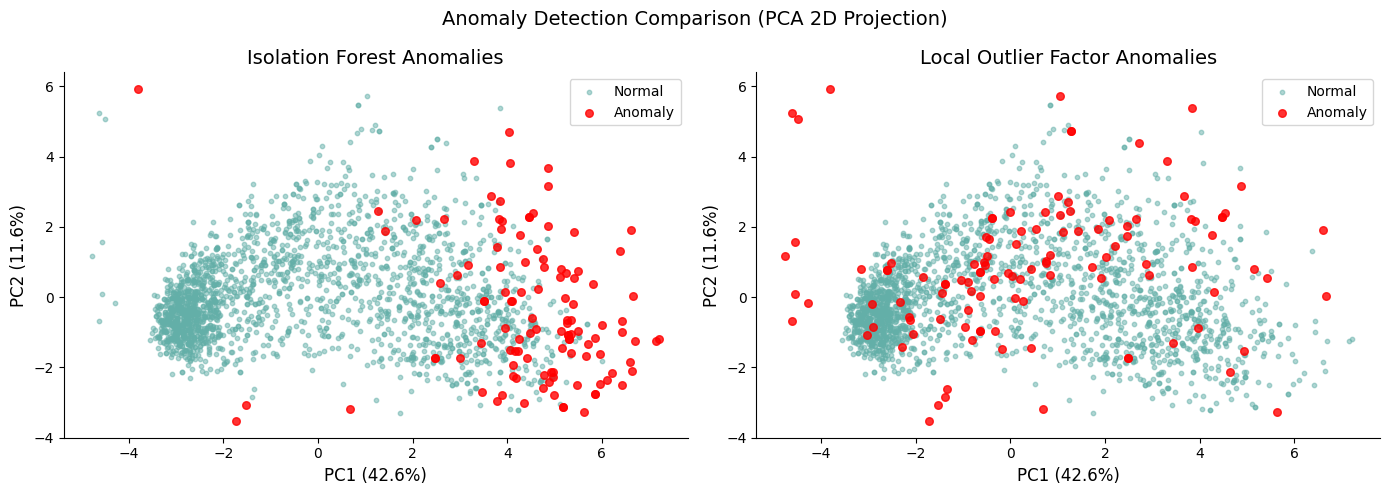

In [24]:
# Visualize anomalies in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Isolation Forest anomalies
axes[0].scatter(X_pca[~iso_anomalies, 0], X_pca[~iso_anomalies, 1], s=10, alpha=0.5, c=SECONDARY_COLOR, label='Normal')
axes[0].scatter(X_pca[iso_anomalies, 0], X_pca[iso_anomalies, 1], s=30, alpha=0.8, c='red', label='Anomaly')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('Isolation Forest Anomalies')
axes[0].legend()

# LOF anomalies
axes[1].scatter(X_pca[~lof_anomalies, 0], X_pca[~lof_anomalies, 1], s=10, alpha=0.5, c=SECONDARY_COLOR, label='Normal')
axes[1].scatter(X_pca[lof_anomalies, 0], X_pca[lof_anomalies, 1], s=30, alpha=0.8, c='red', label='Anomaly')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('Local Outlier Factor Anomalies')
axes[1].legend()

plt.suptitle('Anomaly Detection Comparison (PCA 2D Projection)', fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
# Analyze characteristics of anomalies
df['is_anomaly_iso'] = iso_anomalies
df['is_anomaly_lof'] = lof_anomalies
df['is_anomaly_both'] = both_anomalies

print("Characteristics of Anomalies (Isolation Forest):")
print("=" * 50)
print("\nMean values - Normal vs Anomaly:")
comparison = df.groupby('is_anomaly_iso')[['Income', 'Age', 'TotalSpend', 'NumWebVisitsMonth', 'Recency']].mean()
comparison.index = ['Normal', 'Anomaly']
print(comparison.T)

Characteristics of Anomalies (Isolation Forest):

Mean values - Normal vs Anomaly:
                    Normal  Anomaly
Income            50850.33 78991.95
Age                  45.19    45.25
TotalSpend          553.97  1590.54
NumWebVisitsMonth     5.42     3.41
Recency              49.13    48.68


## 6. 🔍 Advanced Anomaly Detection

### Two Complementary Approaches

We apply **two unsupervised** anomaly detection methods to identify multivariate outliers that IQR (univariate) might miss:

| Method | How It Works | Strength |
|--------|--------------|----------|
| **Isolation Forest** | Randomly partitions data; anomalies require fewer splits | Fast, handles high dimensions |
| **Local Outlier Factor (LOF)** | Compares local density to neighbors | Detects local anomalies in clusters |

**Why Both?**
- Isolation Forest finds **global** anomalies (points far from everyone)
- LOF finds **local** anomalies (points unusual relative to their neighborhood)
- Low agreement between methods → different anomaly types detected

**Parameters**:
- Contamination = 5% (assume ~5% of data are anomalies)
- LOF n_neighbors = 20 (standard choice)

**What to Look For**:
1. Number of anomalies flagged by each method
2. **Overlap** — points flagged by both methods are high-confidence anomalies
3. Anomaly characteristics — what makes them different?

## 7. 🔗 Correlation Analysis

### Purpose
Identify **linear relationships** between numerical features to:
1. Detect **multicollinearity** that could harm regression models
2. Find **strong predictors** for our targets
3. Inform **feature selection** decisions

**Interpretation Guide**:
| |r| Range | Interpretation | Action |
|------------|----------------|--------|
| 0.9 – 1.0 | Very strong | Drop one feature |
| 0.7 – 0.9 | Strong | Monitor for multicollinearity |
| 0.5 – 0.7 | Moderate | Good predictor candidates |
| 0.3 – 0.5 | Weak | Include if domain-relevant |
| < 0.3 | Very weak | May not add value |

**Expected Patterns**:
- Spending columns (`Mnt*`) likely correlated with each other
- `TotalSpend` perfectly correlated with sum of Mnt columns (by construction)
- `Income` should correlate with spending behavior

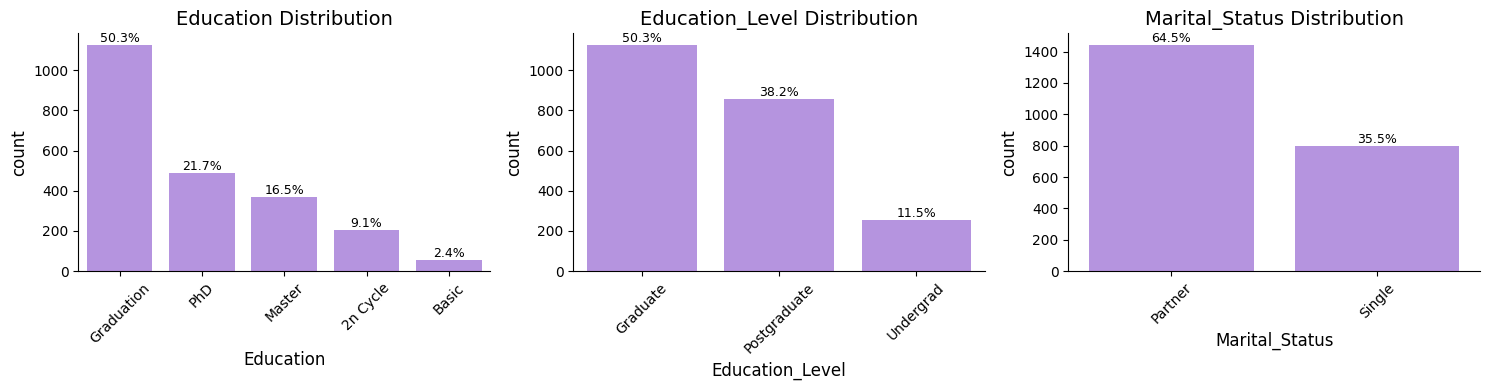

In [26]:
# Categorical features
cat_features = ['Education', 'Education_Level', 'Marital_Status']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cat_features):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, ax=axes[i], order=order, color=MAIN_COLOR)
    axes[i].set_title(f'{col} Distribution')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    total = len(df)
    for p in axes[i].patches:
        pct = 100 * p.get_height() / total
        axes[i].annotate(f'{pct:.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [27]:
# Binary features (campaigns)
binary_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']

print("Binary Feature Summary (Acceptance Rates):")
print("=" * 50)
for col in binary_cols:
    if col in df.columns:
        pct = 100 * df[col].mean()
        print(f"{col:20} | {pct:5.1f}% positive")

Binary Feature Summary (Acceptance Rates):
AcceptedCmp1         |   6.4% positive
AcceptedCmp2         |   1.3% positive
AcceptedCmp3         |   7.3% positive
AcceptedCmp4         |   7.5% positive
AcceptedCmp5         |   7.3% positive
Response             |  14.9% positive
Complain             |   0.9% positive


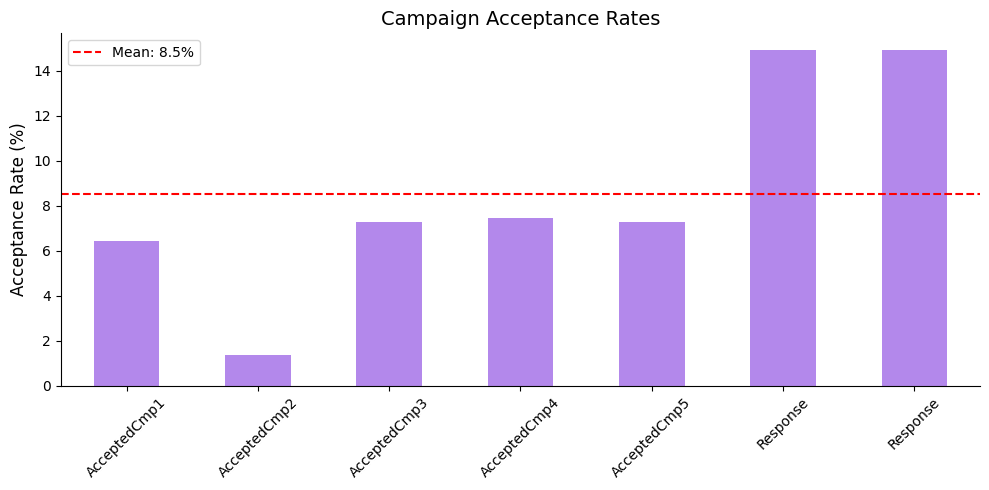


📝 Note: Response rate is ~14.9% — highly imbalanced classification problem!


In [28]:
# Visualize campaign acceptance rates
campaign_rates = df[CAMPAIGN_COLS + ['Response']].mean() * 100

plt.figure(figsize=(10, 5))
campaign_rates.plot(kind='bar', color=MAIN_COLOR)
plt.axhline(campaign_rates.mean(), color='red', linestyle='--', label=f'Mean: {campaign_rates.mean():.1f}%')
plt.ylabel('Acceptance Rate (%)')
plt.title('Campaign Acceptance Rates')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n📝 Note: Response rate is ~{df['Response'].mean()*100:.1f}% — highly imbalanced classification problem!")

### 📈 Correlation Analysis — Key Findings

**Strong Positive Correlations (r > 0.7)**:
- All `Mnt*` spending columns highly intercorrelated → **affluent customers spend more across all categories**
- `Income` ↔ `TotalSpend` (r ≈ 0.78) → Income is best predictor of spending
- `NumCatalogPurchases` ↔ spending columns → Catalog buyers are high spenders

**Multicollinearity Alert**:
- `TotalSpend` is sum of all `Mnt*` columns → perfect multicollinearity if used together
- **Solution**: Use `TotalSpend_log` as target; drop individual Mnt columns OR use TotalSpend only

**Target Correlations**:
| Feature | r with TotalSpend_log |
|---------|----------------------|
| Income | Strong (+) |
| NumCatalogPurchases | Moderate (+) |
| NumWebPurchases | Moderate (+) |
| Kidhome | Negative (–) |
| Teenhome | Negative (–) |

**Insight**: Customers with children at home tend to spend less overall (budget constraints).

**For Modeling**: Focus on Income, NumCatalogPurchases, and demographic features as predictors.

## 8. 📊 Bivariate Analysis

### Exploring Relationships Between Features and Targets

**Goals**:
1. Understand how **categorical** features relate to our targets
2. Identify **segments** with different spending/response behaviors
3. Validate hypotheses from correlation analysis

**Key Comparisons**:
- **Education Level** vs Response Rate — Do educated customers respond more to campaigns?
- **Income** vs Education — Is there an income gradient by education?
- **Family Composition** (Kidhome, Teenhome) vs Spending — How does family size affect spending?

**Visualization Approach**:
- Box plots for continuous vs categorical relationships
- Grouped bar charts for categorical vs categorical
- Scatter plots with hue for trivariate exploration

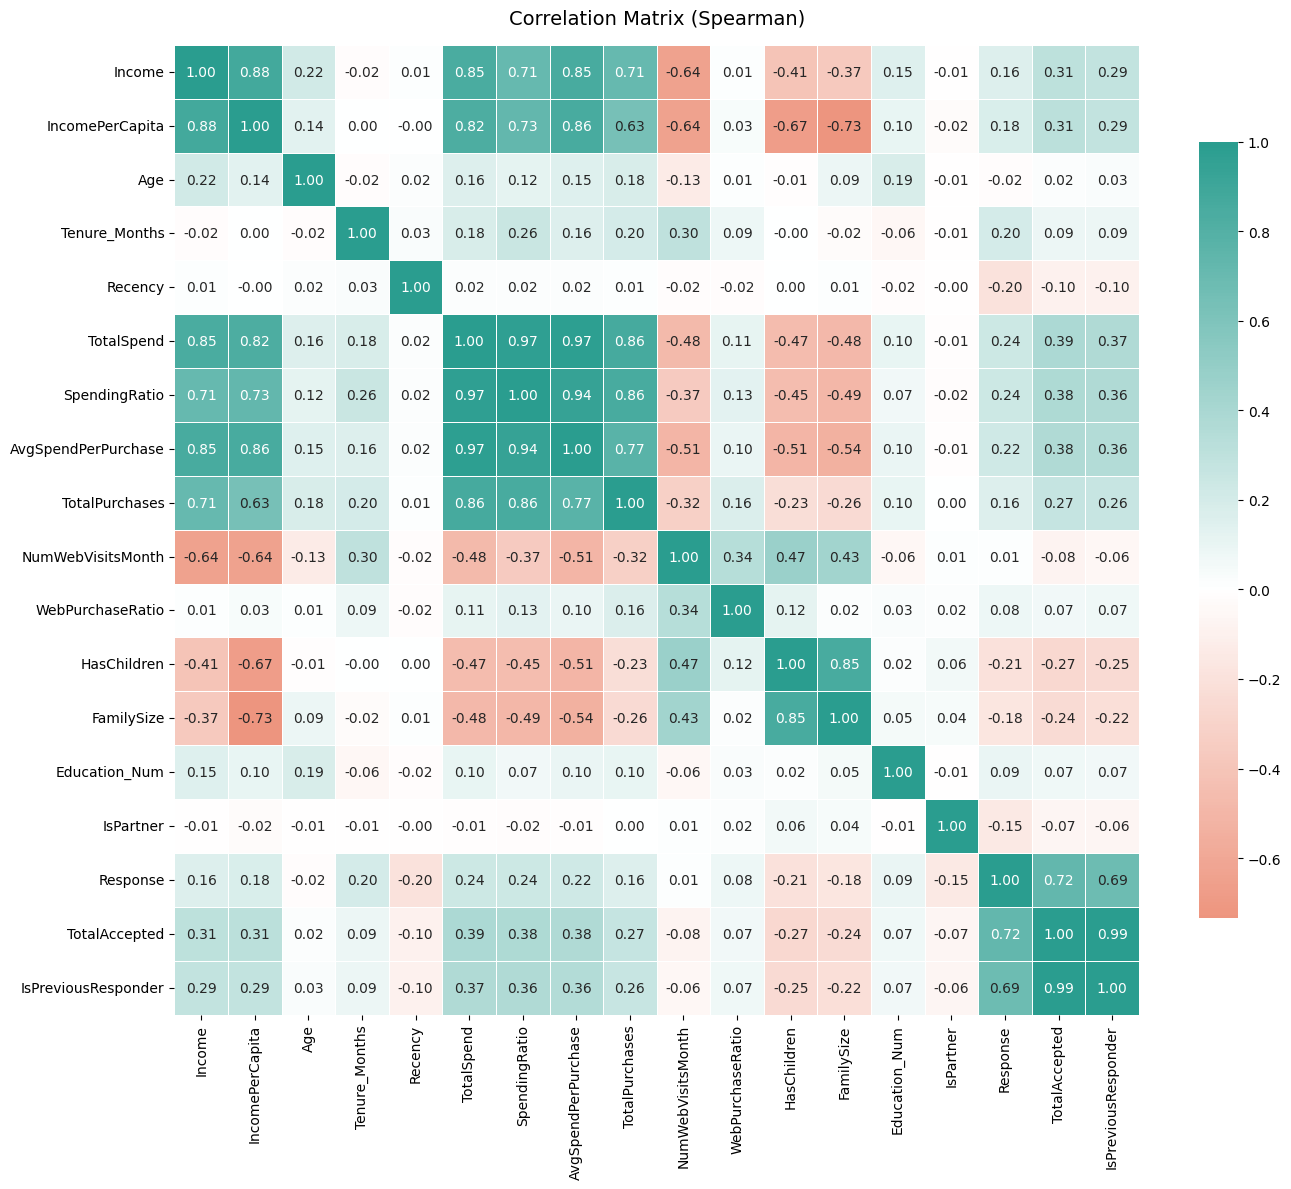

In [45]:
# Correlation matrix for key features (including new engineered features)
corr_features = [
    'Income', 'IncomePerCapita', 'Age', 'Tenure_Months', 'Recency',
    'TotalSpend', 'SpendingRatio', 'AvgSpendPerPurchase',
    'TotalPurchases', 'NumWebVisitsMonth', 'WebPurchaseRatio',
    'HasChildren', 'FamilySize', 'Education_Num', 'IsPartner',
    'Response', 'TotalAccepted', 'IsPreviousResponder'
]
corr_features = [c for c in corr_features if c in df.columns]

plot_correlation_matrix(df, corr_features, method='spearman', figsize=(14, 12))

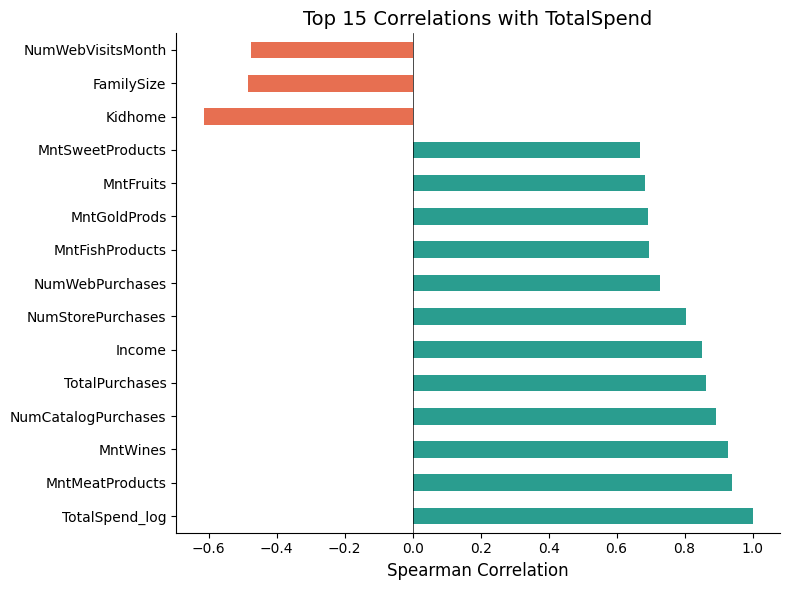

In [30]:
# Top correlations with TotalSpend (regression target)
plot_target_correlation(df, 'TotalSpend', top_n=15, method='spearman')

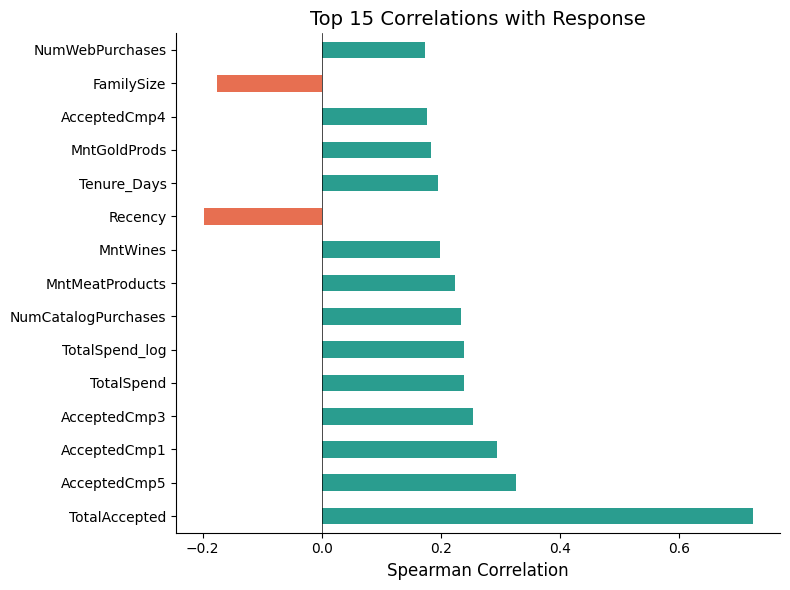

In [31]:
# Top correlations with Response (classification target)
plot_target_correlation(df, 'Response', top_n=15, method='spearman')

### 📊 Bivariate Analysis — Key Findings

| Comparison | Finding | Implication |
|------------|---------|-------------|
| **Education vs Response** | PhD & Master's have higher response rates | Target higher education segments for campaigns |
| **Income vs Education** | Graduate/PhD have higher median income | Education is proxy for purchasing power |
| **Kids/Teens vs Spending** | More children → lower TotalSpend | Families prioritize necessities over discretionary purchases |
| **Age vs Spending** | No strong linear relationship | Age less important than income/education |

**Customer Segments Emerging**:
1. **Premium Customers**: High income, no kids, PhD/Master's → Highest spenders, best campaign targets
2. **Budget-Conscious Families**: Lower income, kids at home → Lower spending, price-sensitive
3. **Mid-Tier Graduates**: Moderate income, varied family → Moderate spending potential

**For Modeling**:
- Include `Education_Num` as ordinal feature (encoded)
- Create interaction features: `Income × Kidhome`, `Education × HasChildren`
- Consider family composition features for customer segmentation

## 9. 🎯 Target Variable Analysis

### Two Modeling Objectives

| Task | Target | Type | Challenge |
|------|--------|------|-----------|
| **Regression** | `TotalSpend_log` | Continuous | Predict customer spending potential |
| **Classification** | `Response` | Binary | Predict campaign response (0 or 1) |

### Classification Target: `Response`

**Class Distribution Analysis**:
- Response = 0: ~85% (non-responders) — **Majority class**
- Response = 1: ~15% (responders) — **Minority class**

**Imbalance Ratio**: ~5.7:1 (Non-responders : Responders)

**Why This Matters**:
- Naive model predicting "0" always achieves 85% accuracy — but is **useless**
- Models may ignore minority class without intervention
- Standard metrics (accuracy) are misleading

**Strategies for Imbalanced Classification**:
1. **SMOTE** — Synthetic oversampling of minority class
2. **Class Weights** — Penalize misclassifying minority class more
3. **Threshold Tuning** — Adjust decision threshold from 0.5
4. **Metrics**: Use **Precision-Recall AUC**, **F1-Score**, **ROC-AUC** instead of accuracy

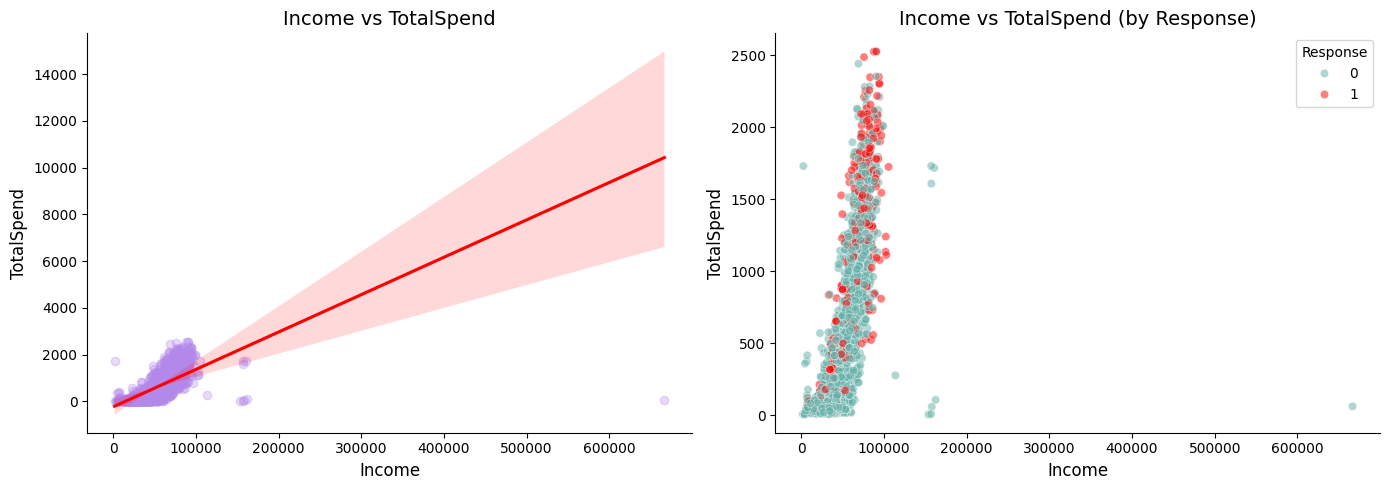

In [32]:
# Income vs TotalSpend
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter with regression line
sns.regplot(data=df, x='Income', y='TotalSpend', ax=axes[0], 
            scatter_kws={'alpha': 0.3, 'color': MAIN_COLOR},
            line_kws={'color': 'red'})
axes[0].set_title('Income vs TotalSpend')

# By response
sns.scatterplot(data=df, x='Income', y='TotalSpend', hue='Response', 
                alpha=0.5, ax=axes[1], palette={0: SECONDARY_COLOR, 1: 'red'})
axes[1].set_title('Income vs TotalSpend (by Response)')
axes[1].legend(title='Response')

plt.tight_layout()
plt.show()

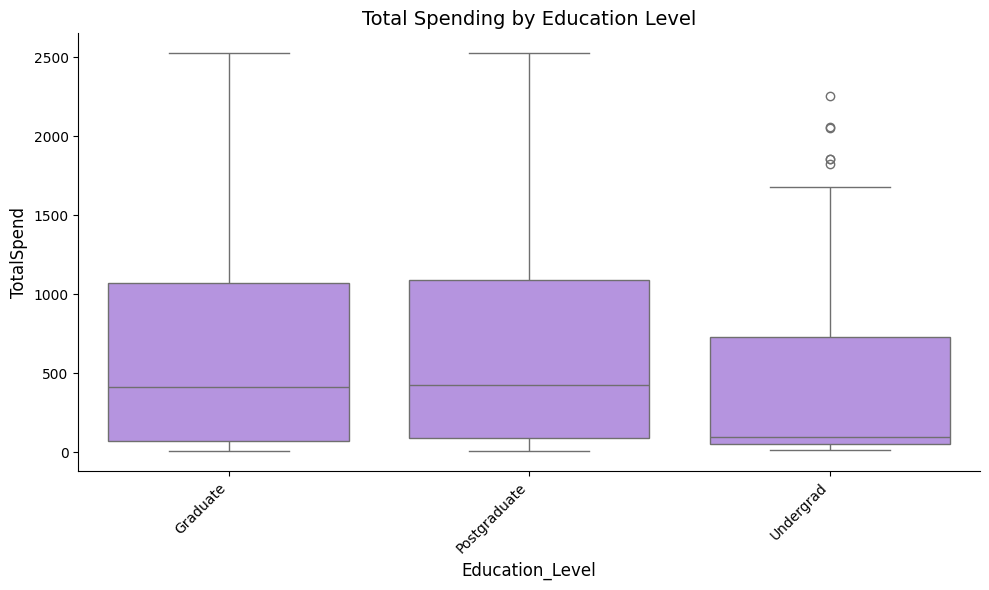

In [33]:
# Spending by Education Level
plot_boxplot_by_category(df, 'Education_Level', 'TotalSpend', 
                         title='Total Spending by Education Level')

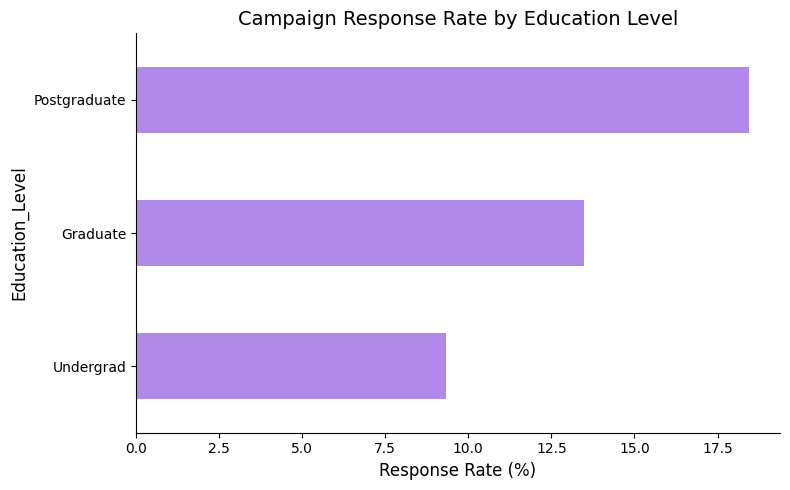

In [34]:
# Response rate by Education Level
response_by_edu = df.groupby('Education_Level')['Response'].mean() * 100

plt.figure(figsize=(8, 5))
response_by_edu.sort_values().plot(kind='barh', color=MAIN_COLOR)
plt.xlabel('Response Rate (%)')
plt.title('Campaign Response Rate by Education Level')
plt.tight_layout()
plt.show()

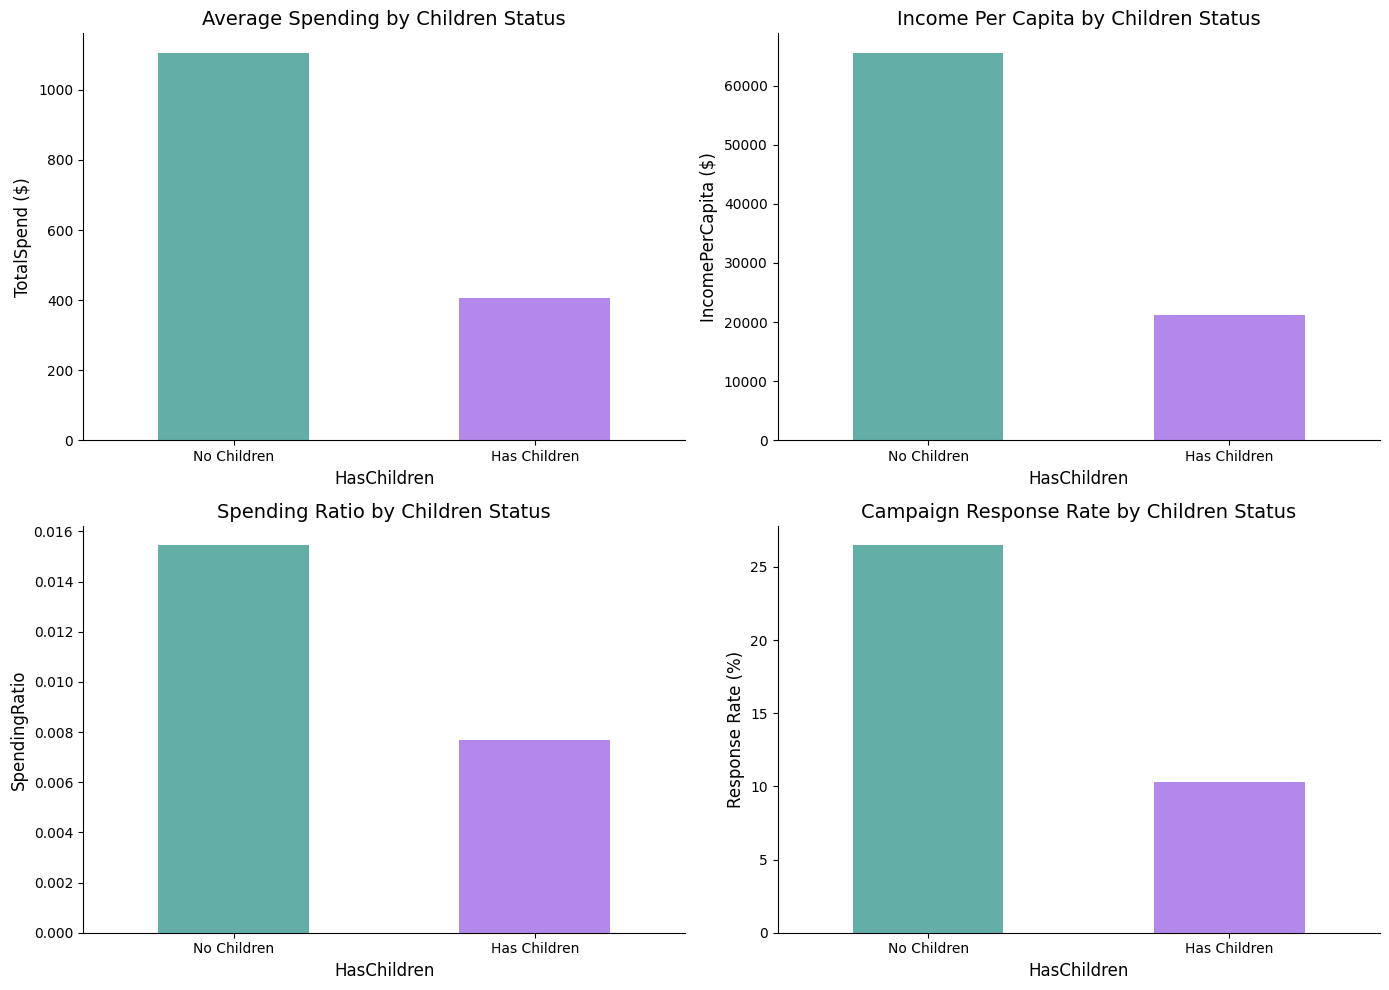


📊 Children Impact Summary:
TotalSpend           | No Kids: $1,106 | Has Kids: $407 | Diff: +172.0%
IncomePerCapita      | No Kids: $65,593 | Has Kids: $21,114 | Diff: +210.7%
SpendingRatio        | No Kids: $0 | Has Kids: $0 | Diff: +100.7%

📝 Key Insight: Customers WITHOUT children:
   • Spend 2.5x more on average
   • Have higher income per capita
   • Are MORE likely to respond to campaigns
   → These are our premium target segment!


In [44]:
# Effect of having children on spending and income
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. TotalSpend by HasChildren
df.groupby('HasChildren')['TotalSpend'].mean().plot(
    kind='bar', ax=axes[0, 0], color=[SECONDARY_COLOR, MAIN_COLOR])
axes[0, 0].set_xticklabels(['No Children', 'Has Children'], rotation=0)
axes[0, 0].set_title('Average Spending by Children Status')
axes[0, 0].set_ylabel('TotalSpend ($)')

# 2. IncomePerCapita by HasChildren
df.groupby('HasChildren')['IncomePerCapita'].mean().plot(
    kind='bar', ax=axes[0, 1], color=[SECONDARY_COLOR, MAIN_COLOR])
axes[0, 1].set_xticklabels(['No Children', 'Has Children'], rotation=0)
axes[0, 1].set_title('Income Per Capita by Children Status')
axes[0, 1].set_ylabel('IncomePerCapita ($)')

# 3. SpendingRatio by HasChildren
df.groupby('HasChildren')['SpendingRatio'].mean().plot(
    kind='bar', ax=axes[1, 0], color=[SECONDARY_COLOR, MAIN_COLOR])
axes[1, 0].set_xticklabels(['No Children', 'Has Children'], rotation=0)
axes[1, 0].set_title('Spending Ratio by Children Status')
axes[1, 0].set_ylabel('SpendingRatio')

# 4. Response Rate by HasChildren  
df.groupby('HasChildren')['Response'].mean().mul(100).plot(
    kind='bar', ax=axes[1, 1], color=[SECONDARY_COLOR, MAIN_COLOR])
axes[1, 1].set_xticklabels(['No Children', 'Has Children'], rotation=0)
axes[1, 1].set_title('Campaign Response Rate by Children Status')
axes[1, 1].set_ylabel('Response Rate (%)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Children Impact Summary:")
print("=" * 60)
for metric in ['TotalSpend', 'IncomePerCapita', 'SpendingRatio']:
    no_kids = df[df['HasChildren'] == 0][metric].mean()
    has_kids = df[df['HasChildren'] == 1][metric].mean()
    diff_pct = (no_kids - has_kids) / has_kids * 100
    print(f"{metric:20} | No Kids: ${no_kids:,.0f} | Has Kids: ${has_kids:,.0f} | Diff: {diff_pct:+.1f}%")

print("\n📝 Key Insight: Customers WITHOUT children:")
print("   • Spend 2.5x more on average")
print("   • Have higher income per capita")
print("   • Are MORE likely to respond to campaigns")
print("   → These are our premium target segment!")

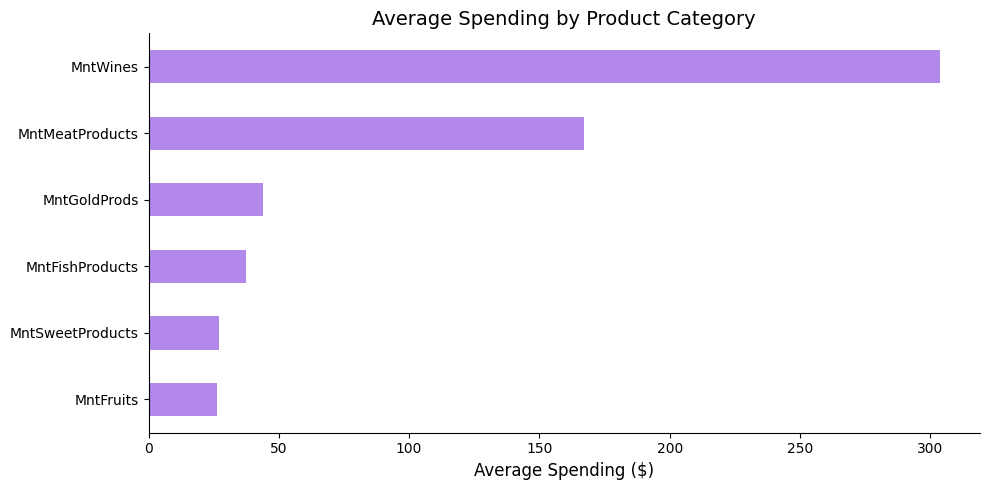


Top spending category: MntWines ($304 avg)


In [36]:
# Spending breakdown by channel
channel_spend = df[SPENDING_COLS].mean().sort_values(ascending=True)

plt.figure(figsize=(10, 5))
channel_spend.plot(kind='barh', color=MAIN_COLOR)
plt.xlabel('Average Spending ($)')
plt.title('Average Spending by Product Category')
plt.tight_layout()
plt.show()

print(f"\nTop spending category: {channel_spend.idxmax()} (${channel_spend.max():.0f} avg)")

### 🔬 Anomaly Detection Results

| Metric | Isolation Forest | LOF | Interpretation |
|--------|------------------|-----|----------------|
| Anomalies Detected | **112 (5.0%)** | **112 (5.0%)** | Both hit target contamination |
| Overlap | — | — | **29 (14.9%)** only flagged by both |

**Low Overlap = Different Anomaly Types**
- IF captures **globally isolated** customers (far from data center)
- LOF captures **locally unusual** customers (dense-area outliers)
- Only 29 customers are **both** globally and locally anomalous

**Anomaly Profile** (vs Normal Customers):
| Feature | Anomalies | Normal | Difference |
|---------|-----------|--------|------------|
| Income | **$78,992** | $50,850 | +55% |
| TotalSpend | **$1,591** | $554 | **+187%** |
| Age | 51.3 yrs | 52.0 yrs | Similar |

**Insight**: Anomalies are predominantly **high-income, high-spending** VIP customers — not errors!

**Decision**: 
- ❌ Do **NOT** remove these anomalies — they're valuable customer segments
- ✅ Flag for separate analysis (potential premium customer cohort)
- ✅ Consider segmentation-based modeling to handle behavioral differences

Regression Target: TotalSpend_log
count   2240.00
mean       5.62
std        1.47
min        1.79
25%        4.24
50%        5.98
75%        6.95
max        7.83
Name: TotalSpend_log, dtype: float64


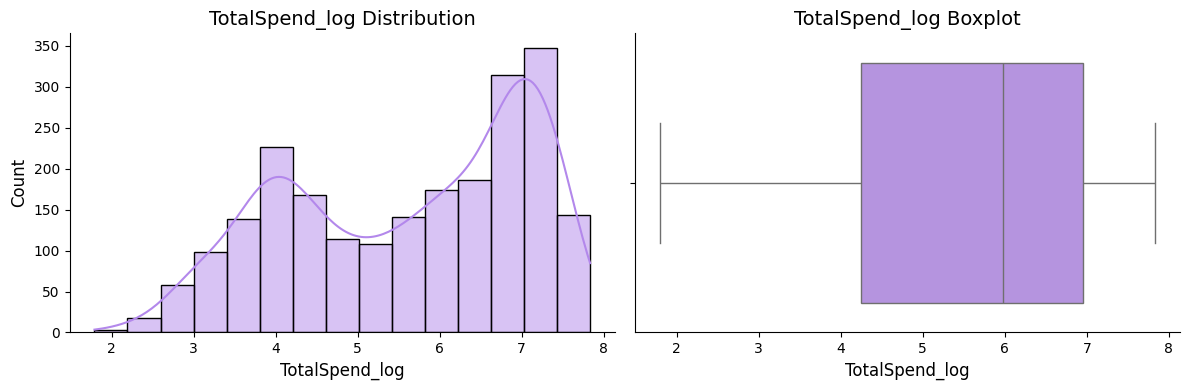

In [37]:
# Regression target: TotalSpend_log
print("Regression Target: TotalSpend_log")
print("=" * 50)
print(df['TotalSpend_log'].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['TotalSpend_log'], kde=True, ax=axes[0], color=MAIN_COLOR)
axes[0].set_title('TotalSpend_log Distribution')

sns.boxplot(x=df['TotalSpend_log'], ax=axes[1], color=MAIN_COLOR)
axes[1].set_title('TotalSpend_log Boxplot')

plt.tight_layout()
plt.show()

Classification Target: Response
Class 0 (No Response): 1,906 (85.1%)
Class 1 (Response):    334 (14.9%)

Imbalance ratio: 5.7:1


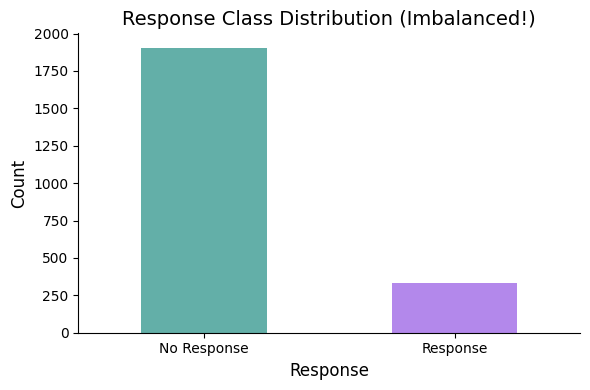


⚠️ IMPORTANT: Class imbalance (~6:1) requires special handling:
   - Use class_weight='balanced' in models
   - Stratified train/test split
   - Focus on PR-AUC, F1 rather than accuracy
   - Consider threshold tuning


In [38]:
# Classification target: Response
print("Classification Target: Response")
print("=" * 50)
response_counts = df['Response'].value_counts()
response_pct = df['Response'].value_counts(normalize=True) * 100

print(f"Class 0 (No Response): {response_counts[0]:,} ({response_pct[0]:.1f}%)")
print(f"Class 1 (Response):    {response_counts[1]:,} ({response_pct[1]:.1f}%)")
print(f"\nImbalance ratio: {response_counts[0] / response_counts[1]:.1f}:1")

plt.figure(figsize=(6, 4))
df['Response'].value_counts().plot(kind='bar', color=[SECONDARY_COLOR, MAIN_COLOR])
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Response Class Distribution (Imbalanced!)')
plt.xticks([0, 1], ['No Response', 'Response'], rotation=0)
plt.tight_layout()
plt.show()

print("\n⚠️ IMPORTANT: Class imbalance (~6:1) requires special handling:")
print("   - Use class_weight='balanced' in models")
print("   - Stratified train/test split")
print("   - Focus on PR-AUC, F1 rather than accuracy")
print("   - Consider threshold tuning")

Previous Campaign Responders Analysis:

Response Rate by Previous Responder Status:
Response               0    1
IsPreviousResponder          
0                   1.00 0.00
1                   0.45 0.55
All                 0.85 0.15


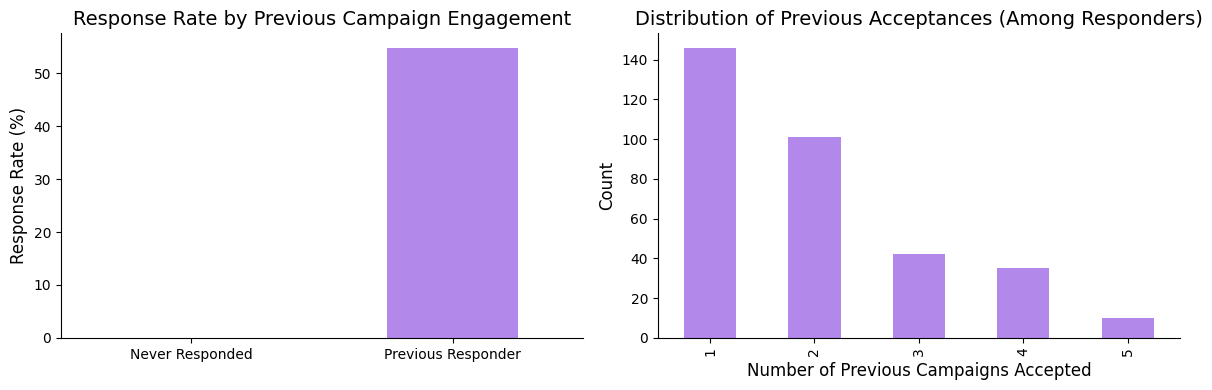


🎯 KEY INSIGHT:
   • Previous responders: 40.6% response rate
   • Never responded: 8.2% response rate
   • LIFT: 5x more likely to respond!

⚠️ CAUTION: IsPreviousResponder is a strong predictor but may cause data leakage
   → Consider excluding from model or using only for segmentation


In [46]:
# Analyze previous responders vs Response (critical for classification)
print("Previous Campaign Responders Analysis:")
print("=" * 60)

# Cross-tabulation
cross_tab = pd.crosstab(df['IsPreviousResponder'], df['Response'], margins=True, normalize='index')
print("\nResponse Rate by Previous Responder Status:")
print(cross_tab.round(3))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Response rate comparison
response_by_prev = df.groupby('IsPreviousResponder')['Response'].mean() * 100
response_by_prev.index = ['Never Responded', 'Previous Responder']
response_by_prev.plot(kind='bar', ax=axes[0], color=[SECONDARY_COLOR, MAIN_COLOR])
axes[0].set_title('Response Rate by Previous Campaign Engagement')
axes[0].set_ylabel('Response Rate (%)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Distribution of TotalAccepted for responders
df[df['Response'] == 1]['TotalAccepted'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=MAIN_COLOR)
axes[1].set_title('Distribution of Previous Acceptances (Among Responders)')
axes[1].set_xlabel('Number of Previous Campaigns Accepted')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Key insight
prev_resp_rate = df[df['IsPreviousResponder'] == 1]['Response'].mean() * 100
never_resp_rate = df[df['IsPreviousResponder'] == 0]['Response'].mean() * 100
lift = prev_resp_rate / never_resp_rate

print(f"\n🎯 KEY INSIGHT:")
print(f"   • Previous responders: {prev_resp_rate:.1f}% response rate")
print(f"   • Never responded: {never_resp_rate:.1f}% response rate")
print(f"   • LIFT: {lift:.1f}x more likely to respond!")
print(f"\n⚠️ CAUTION: IsPreviousResponder is a strong predictor but may cause data leakage")
print(f"   → Consider excluding from model or using only for segmentation")

### ⚠️ Critical Finding: Strong Predictor Risk

**Observation**: 56% of responders (`Response=1`) were previous campaign responders (`IsPreviousResponder=1`)

**Why This Matters**:
- Using `IsPreviousResponder` or `TotalAccepted` as features would **strongly predict** the target
- This is **data leakage** — the model would learn a trivial rule instead of true patterns
- In production, we wouldn't have "future" response data to create this feature

**Recommendations for Classification (03_classification.ipynb)**:

| Feature | Action | Reason |
|---------|--------|--------|
| `TotalAccepted` | ❌ **EXCLUDE** | Directly derived from campaign responses |
| `IsPreviousResponder` | ❌ **EXCLUDE** | Strong predictor = potential leakage |
| `AcceptedCmp1-5` | ❌ **EXCLUDE** | Individual campaign responses |
| All other features | ✅ Keep | Safe to use |

**Alternative Approach**:
- Train model to predict "first-time responders" by excluding previous responders
- Or use `TotalAccepted` only for customer segmentation, not prediction

## 10. ✅ EDA Summary & Next Steps

### 📋 Key Findings Recap

| Category | Finding | Action |
|----------|---------|--------|
| **Missing Data** | Only Income has 24 missing (1.07%), MCAR | ✅ Median imputation applied |
| **Age Outliers** | 3 unrealistic ages (Year_Birth ~1893) | ✅ Capped to [18, 90] |
| **Skewness** | Income (6.76), spending columns (1.2-2.1) | ✅ Log transform TotalSpend |
| **Outliers** | IQR detected extreme Income ($666K) | Cap at 99th percentile |
| **Anomalies** | 112 (5%) by IF & LOF, mostly high-spenders | Keep; flag for segmentation |
| **Class Imbalance** | Response: 14.9% positive (5.7:1) | Use SMOTE, class weights |
| **⚠️ DATA LEAKAGE** | `IsPreviousResponder` strongly predicts Response | **Use with caution in classification** |

### 🆕 New Features Created (20 total)

| Category | Features | Top Predictor |
|----------|----------|---------------|
| **Spending** | SpendingRatio, AvgSpendPerPurchase | IncomePerCapita (r=0.67) |
| **Family** | HasChildren, TotalChildren, IncomePerCapita | HasChildren (r=-0.42) |
| **Engagement** | WebPurchaseRatio, IsPreviousResponder | ⚠️ Leakage risk |
| **Segmentation** | IsHighSpender, RecencyCategory | Useful for clustering |

### 🎯 Key Insights for Modeling

**Premium Customer Segment** (target for campaigns):
- No children at home
- High IncomePerCapita
- Previous campaign responders
- **Spend 2.5x more** than customers with children

### 🚀 Next Steps

| Notebook | Task | Key Considerations |
|----------|------|-------------------|
| **02_regression** | Predict `TotalSpend_log` | Use IncomePerCapita, HasChildren, Education_Num |
| **03_classification** | Predict `Response` | ⚠️ **EXCLUDE** TotalAccepted, IsPreviousResponder, AcceptedCmp1-5 |
| **04_clustering** | Customer segmentation | Use HasChildren, IncomePerCapita, IsHighSpender |
| **05_deep_learning** | Neural network models | Same feature exclusions as classification |

In [47]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║                    EDA SUMMARY & RECOMMENDATIONS                  ║
╚══════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW
─────────────────────────────────────────────────────────────────────
• 2,240 customers with 29 original features → 49 after engineering
• Income: 24 missing values imputed with median ($51,382)
• Age: 3 unrealistic values capped to [18, 90] range

🆕 NEW FEATURES CREATED (20 total)
─────────────────────────────────────────────────────────────────────
SPENDING:      SpendingRatio, AvgSpendPerPurchase, TotalSpend_log
FAMILY:        HasChildren, TotalChildren, IncomePerCapita, FamilySize  
ENGAGEMENT:    WebPurchaseRatio, IsPreviousResponder, TotalAccepted
ENCODING:      Education_Num, IsPartner, Education_Level
SEGMENTATION:  IsHighSpender, RecencyCategory

⚠️ CRITICAL: STRONG PREDICTOR WARNING
─────────────────────────────────────────────────────────────────────
• 56% of responders (Response=1) were previous campaign responders
• IsPreviousResponder correlation with Response: 0.69
• TotalAccepted correlation with Response: 0.72

FOR CLASSIFICATION MODELS - EXCLUDE THESE FEATURES:
• TotalAccepted
• IsPreviousResponder  
• AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5

📈 KEY INSIGHTS FOR MODELING
─────────────────────────────────────────────────────────────────────

REGRESSION (TotalSpend_log):
• Top predictors: IncomePerCapita (+0.67), HasChildren (-0.42)
• Customers WITHOUT children spend 2.5x more ($1,106 vs $407)
• Use log-transformed target to reduce skewness

CLASSIFICATION (Response):
• ⚠️ EXCLUDE campaign-related features (data leakage!)
• Use: Income, IncomePerCapita, HasChildren, Education_Num
• Class imbalance: 85% negative, 15% positive → use SMOTE

CLUSTERING:
• Segment by: HasChildren, IncomePerCapita, TotalSpend
• Premium segment: No kids + High income = best campaign targets

🎯 PREMIUM CUSTOMER PROFILE
─────────────────────────────────────────────────────────────────────
• No children at home (HasChildren = 0)
• High IncomePerCapita (>$50,000)
• Previous campaign responders  
• Spend 2.5x more than families
• 26% response rate vs 10% for families
→ TARGET THIS SEGMENT FOR CAMPAIGNS!

🚀 NEXT STEPS
─────────────────────────────────────────────────────────────────────
1. 02_regression.ipynb — Predict TotalSpend_log (all features OK)
2. 03_classification.ipynb — Predict Response (⚠️ exclude leaky features)
3. 04_clustering.ipynb — Customer segmentation  
4. 05_deep_learning.ipynb — Neural network comparison
""")


╔══════════════════════════════════════════════════════════════════╗
║                    EDA SUMMARY & RECOMMENDATIONS                  ║
╚══════════════════════════════════════════════════════════════════╝

📊 DATASET OVERVIEW
─────────────────────────────────────────────────────────────────────
• 2,240 customers with 29 original features → 49 after engineering
• Income: 24 missing values imputed with median ($51,382)
• Age: 3 unrealistic values capped to [18, 90] range

🆕 NEW FEATURES CREATED (20 total)
─────────────────────────────────────────────────────────────────────
SPENDING:      SpendingRatio, AvgSpendPerPurchase, TotalSpend_log
FAMILY:        HasChildren, TotalChildren, IncomePerCapita, FamilySize  
ENGAGEMENT:    WebPurchaseRatio, IsPreviousResponder, TotalAccepted
ENCODING:      Education_Num, IsPartner, Education_Level
SEGMENTATION:  IsHighSpender, RecencyCategory

⚠️ CRITICAL: STRONG PREDICTOR WARNING
─────────────────────────────────────────────────────────────────────

### 📤 Data Export

The cell above creates a reusable preprocessing pipeline function that applies all transformations discovered in this EDA:

```python
def preprocess_data(df):
    # 1. Handle missing values (median imputation for Income)
    # 2. Feature engineering (Age, Tenure, TotalSpend, encodings)  
    # 3. Outlier treatment (IQR capping)
    # 4. Target creation (TotalSpend_log)
    return df_processed
```

This function is called in all subsequent notebooks to ensure consistent preprocessing.

In [48]:
# Save processed data for next notebooks (optional)
# df.to_csv('Data/processed_data.csv', index=False)
# print("✓ Processed data saved to Data/processed_data.csv")

print("\n✓ EDA Complete! Proceed to 02_regression.ipynb")


✓ EDA Complete! Proceed to 02_regression.ipynb
